# Progetto BISF
Alessandro Zanotti 885892

#### Importo le librerie necessarie al funzionamento del notebook

In [1]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from scipy.signal import savgol_filter
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.dates as mdates
from matplotlib import style
import urllib.request
import zipfile
import statsmodels.formula.api as smf

#### Importo i dati dei titoli scelti
- Settore tecnologico: AVGO, NVDA
- Settore sanitario: LLY, PFE
- Settori finanziario: BRK.B, BLK

In [2]:
start_date = '2014-05-31'
end_date = '2024-05-31'
selected_stocks = ["AVGO","NVDA","LLY","PFE","BRK-B","BLK"]

stocks_data = yf.download(selected_stocks, start=start_date, end=end_date)

#Creo un DataFrame contenente solo i dati di chiusura (Adj Close)
adj_close_data = stocks_data['Adj Close']

[*********************100%%**********************]  6 of 6 completed


#### Controllo che il DataFrame non contenga valori nulli
- ES: stock non valida
- ES: stock quotata dopo data di inizio

In [3]:
null_values_count = stocks_data.isnull().sum()
if null_values_count.sum() > 0:
    print(f"DataFrame contains null values:\n{null_values_count}")
else:
    print("DataFrame does not contain null values")

DataFrame does not contain null values


#### Mostro un grafico con l'andamento dei prezzi di chiusura

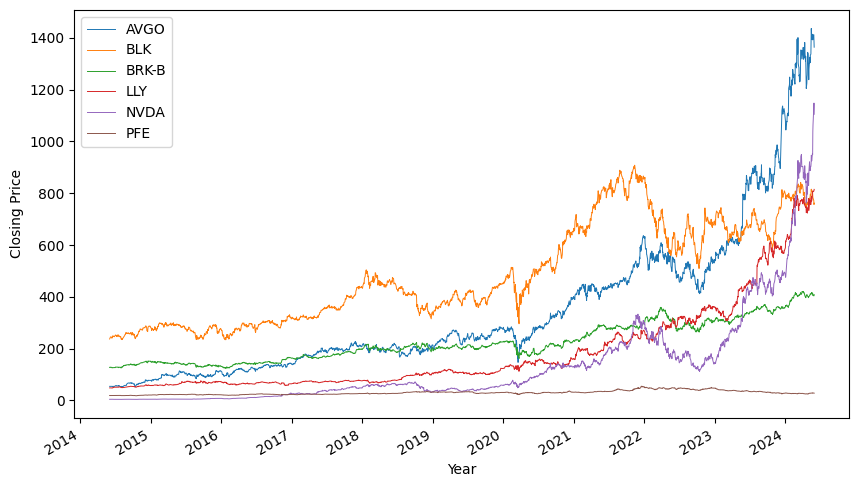

In [4]:
adj_close_data.plot(figsize=(10, 6), linewidth=0.7)
plt.legend()
plt.ylabel('Closing Price')
plt.xlabel('Year')
plt.show()

#### Calcolo dei rendimenti semplici

In [5]:
adjusted_close_returns = adj_close_data.pct_change()
monthly_mean_returns = adjusted_close_returns.groupby(pd.Grouper(freq='ME')).mean()
adjusted_close_returns.dropna(inplace=True)
adjusted_close_returns.head()

Ticker          AVGO       BLK     BRK-B       LLY      NVDA       PFE
Date                                                                  
2014-06-03 -0.002652  0.008430 -0.007429 -0.002353 -0.004224 -0.004039
2014-06-04  0.002239  0.006935  0.002364 -0.002190  0.001061  0.001689
2014-06-05  0.003630  0.003594  0.007624  0.006079  0.004237  0.004049
2014-06-06 -0.003339  0.013003  0.003510  0.000839  0.003692 -0.011425
2014-06-09  0.002234  0.001943 -0.005130  0.001845  0.001051 -0.002379

#### Mostro un grafico con i rendimenti semplici calcolati per azione

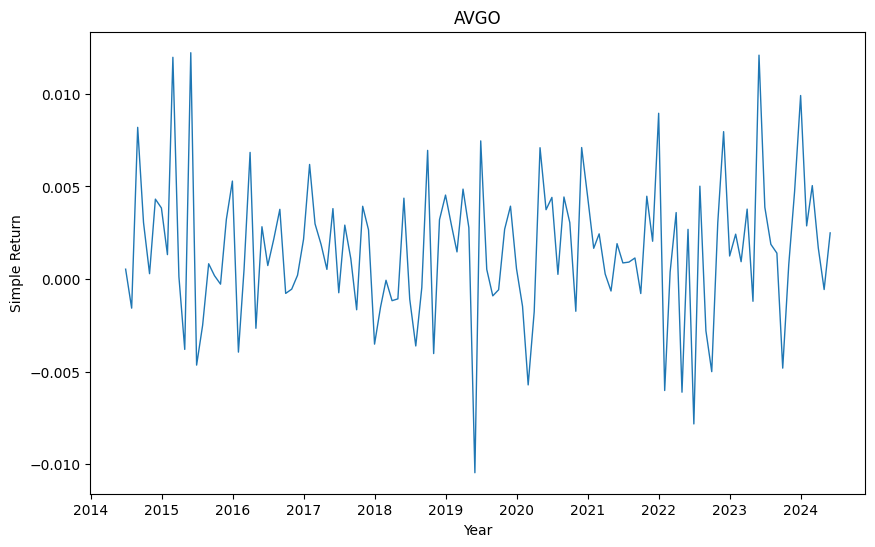

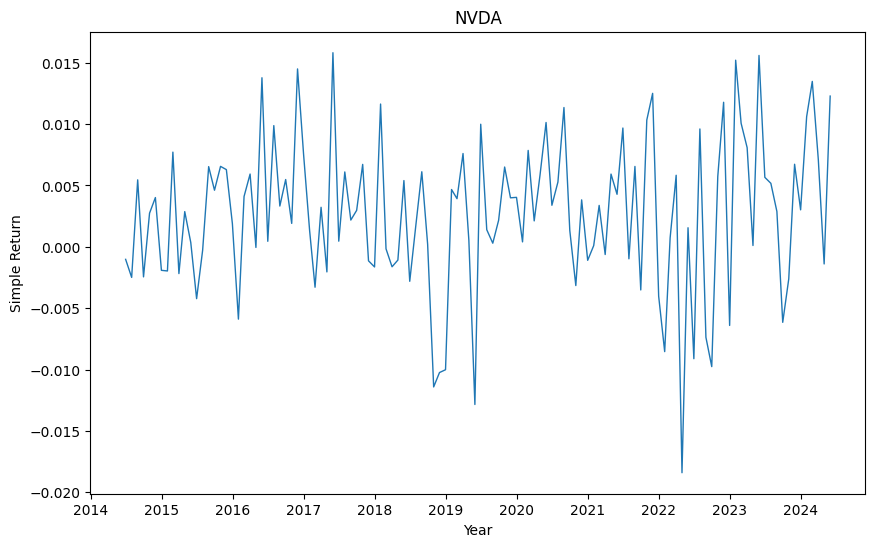

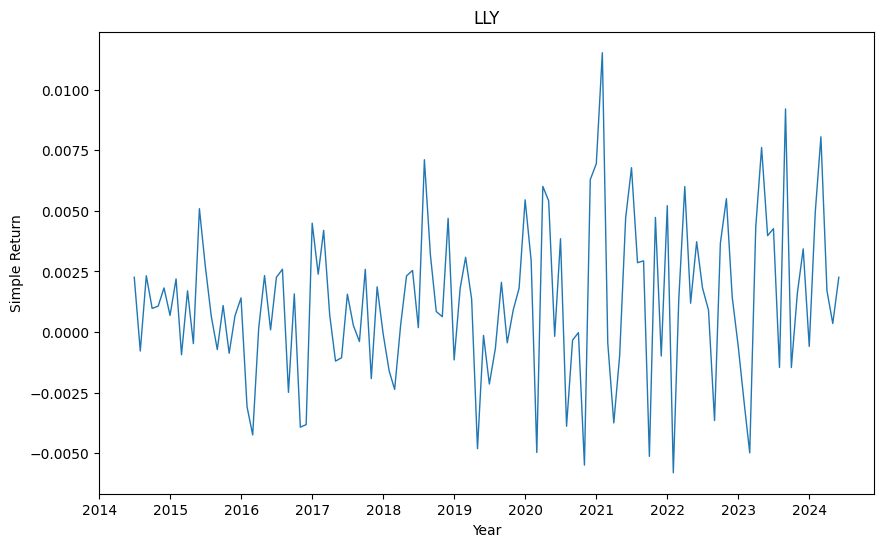

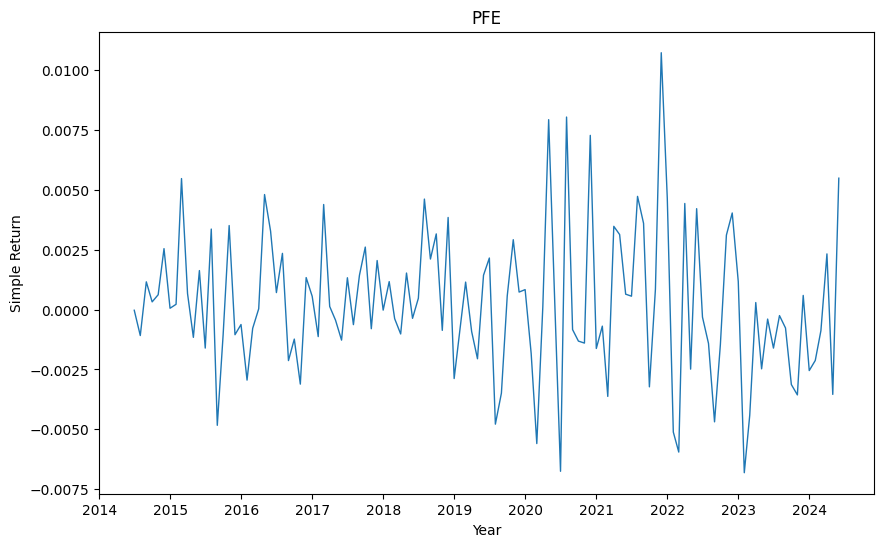

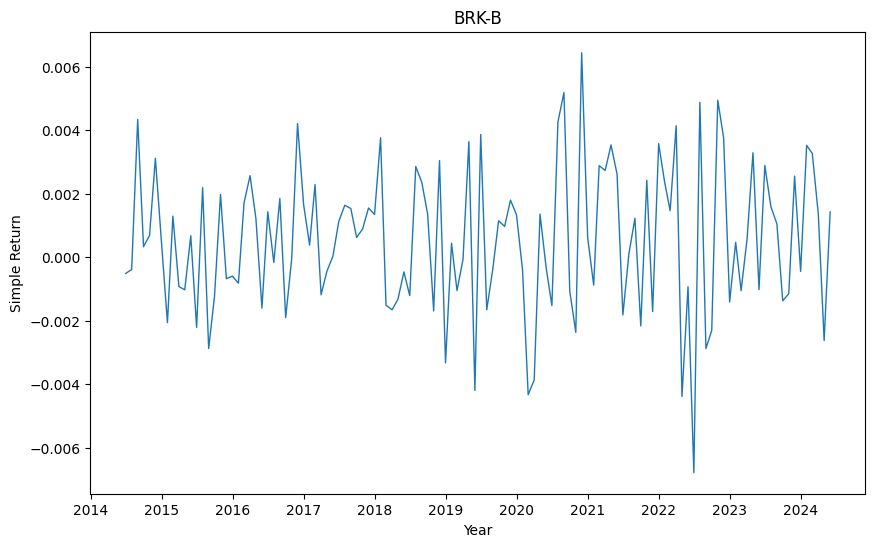

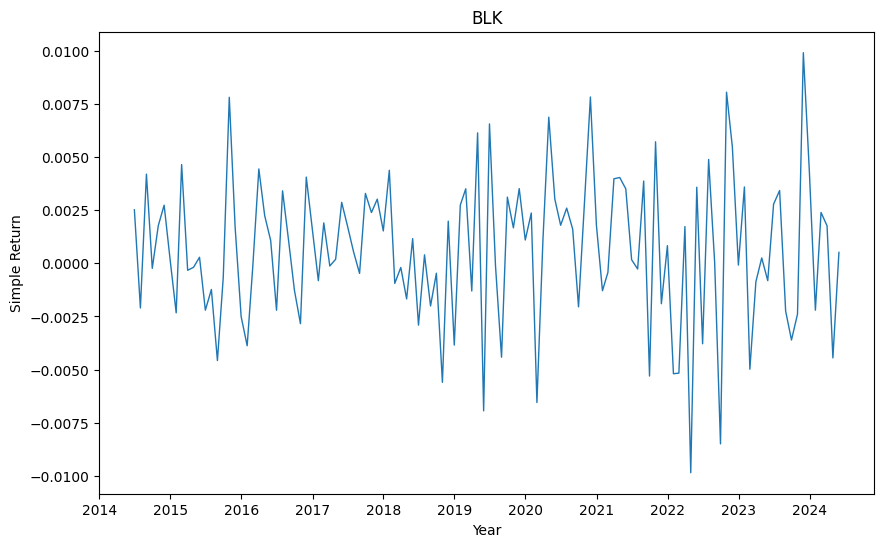

In [6]:
for ticker in selected_stocks:
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_mean_returns[ticker], linewidth=1)
    plt.ylabel('Simple Return')
    plt.xlabel('Year')
    plt.title(ticker)
    plt.show()

#### Calcolo i rendimenti logaritmici

In [7]:
logarithmic_returns = np.log(adj_close_data / adj_close_data.shift(1))
monthly_mean_logarithmic_returns = logarithmic_returns.groupby(pd.Grouper(freq='ME')).mean()
logarithmic_returns.dropna(inplace=True)
logarithmic_returns.head()

Ticker          AVGO       BLK     BRK-B       LLY      NVDA       PFE
Date                                                                  
2014-06-03 -0.002656  0.008395 -0.007457 -0.002356 -0.004233 -0.004047
2014-06-04  0.002237  0.006911  0.002361 -0.002193  0.001060  0.001688
2014-06-05  0.003624  0.003588  0.007595  0.006060  0.004228  0.004041
2014-06-06 -0.003345  0.012919  0.003504  0.000839  0.003685 -0.011491
2014-06-09  0.002231  0.001941 -0.005143  0.001843  0.001051 -0.002382

#### Mostro un grafico con i rendimenti logaritmici calcolati per azione

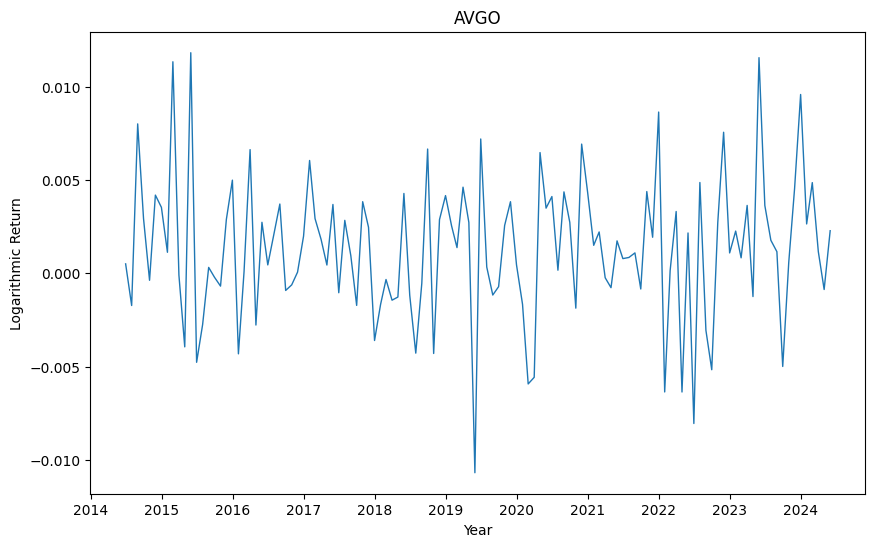

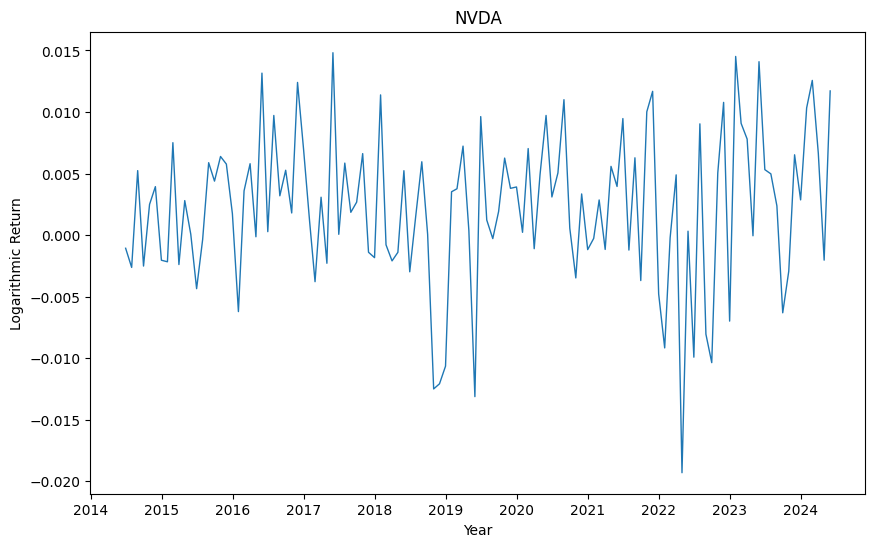

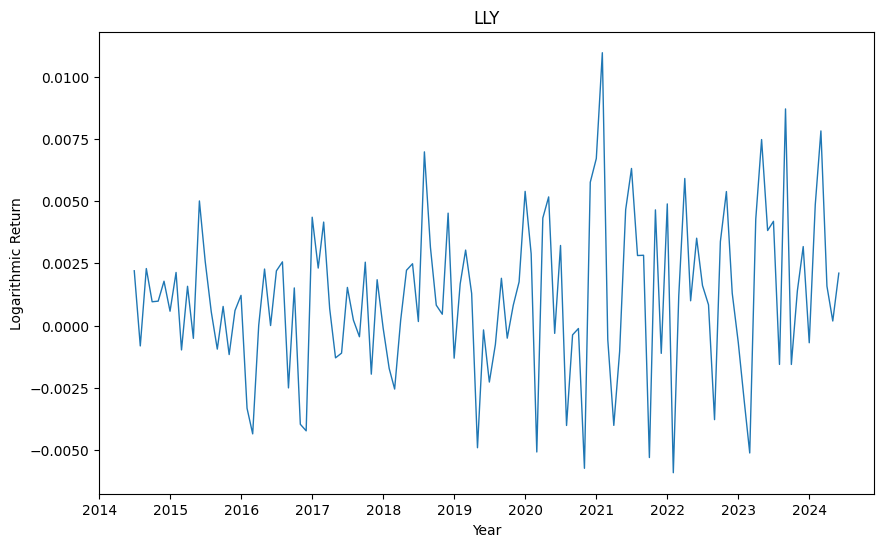

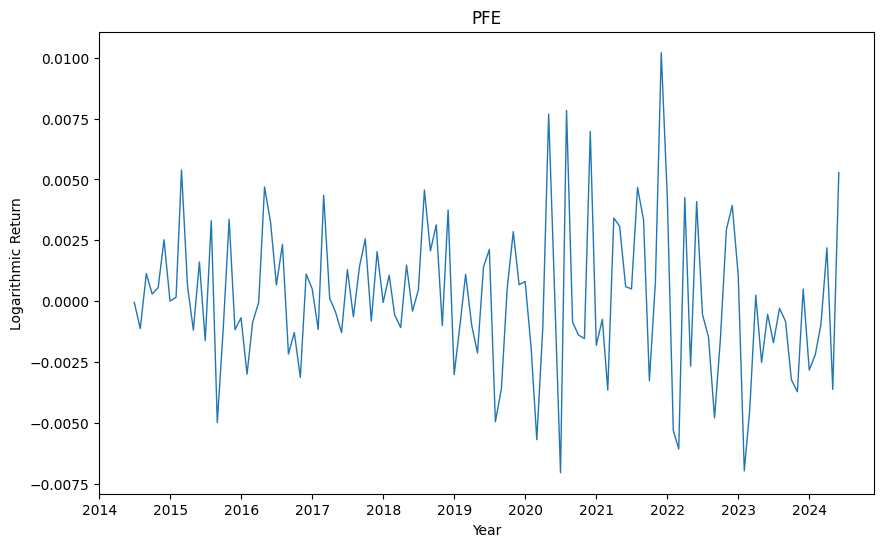

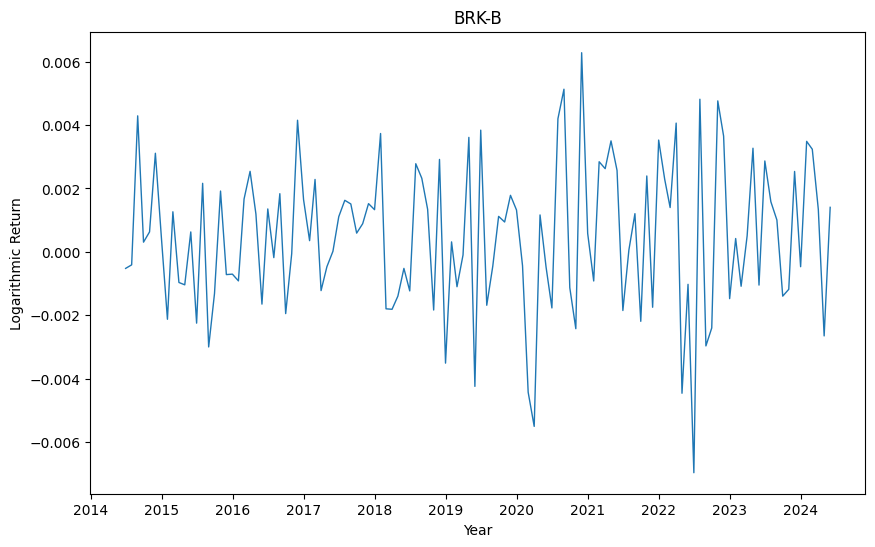

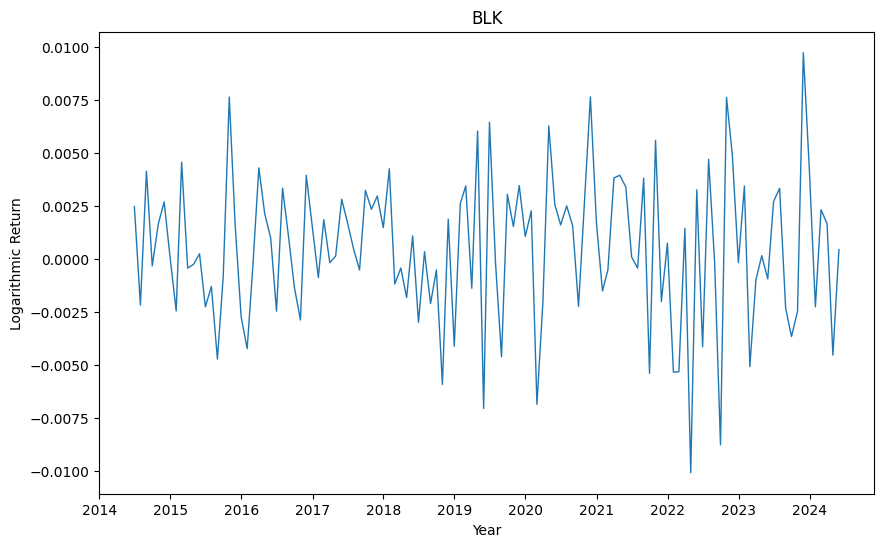

In [8]:
for ticker in selected_stocks:
    plt.figure(figsize=(10, 6))
    plt.plot(monthly_mean_logarithmic_returns[ticker], linewidth=1)
    plt.ylabel('Logarithmic Return')
    plt.xlabel('Year')
    plt.title(ticker)
    plt.show()

#### Calcolo l'aggregazione annuale dei prezzi di chiusura

In [9]:
annual_mean_adj_close = adj_close_data.groupby(pd.Grouper(freq='YE')).mean()

#### Calcolo i rendimenti cumulati annui

In [10]:
cumulative_returns = np.cumprod(1 + adjusted_close_returns)
cumulative_returns.dropna(inplace=True)
print(cumulative_returns)

Ticker           AVGO       BLK     BRK-B        LLY        NVDA       PFE
Date                                                                      
2014-06-03   0.997348  1.008430  0.992571   0.997647    0.995776  0.995961
2014-06-04   0.999582  1.015423  0.994917   0.995462    0.996832  0.997644
2014-06-05   1.003210  1.019073  1.002502   1.001513    1.001056  1.001683
2014-06-06   0.999860  1.032324  1.006021   1.002353    1.004752  0.990239
2014-06-09   1.002094  1.034329  1.000860   1.004202    1.005808  0.987883
...               ...       ...       ...        ...         ...       ...
2024-05-23  25.573624  3.304237  3.173913  16.644245  230.265554  1.491575
2024-05-24  25.840686  3.293076  3.185877  16.623245  236.188616  1.501453
2024-05-28  25.925301  3.248896  3.158430  16.632097  252.675626  1.471299
2024-05-29  25.525534  3.186437  3.159916  16.707656  254.725407  1.446344
2024-05-30  25.037477  3.208675  3.195261  16.780330  245.130916  1.466100

[2516 rows x 6 columns]


#### Mostro un grafico con i rendimenti cumulati annui per azioni

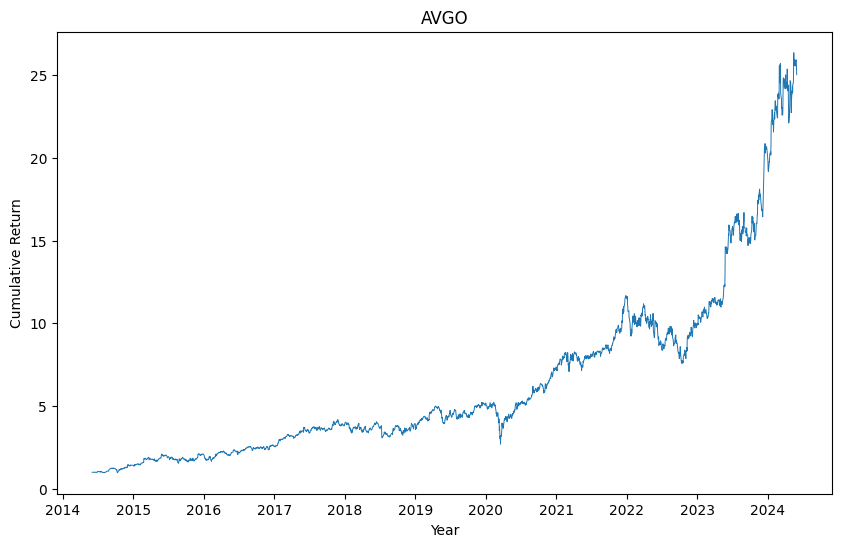

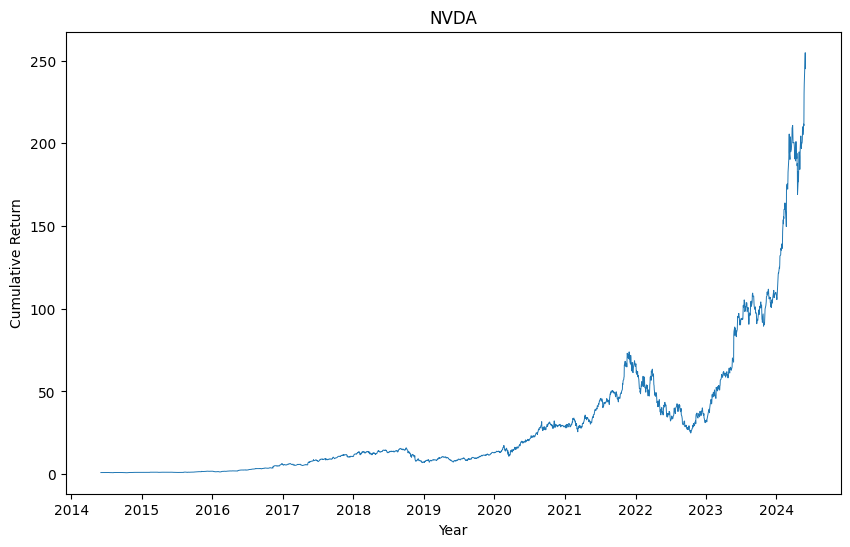

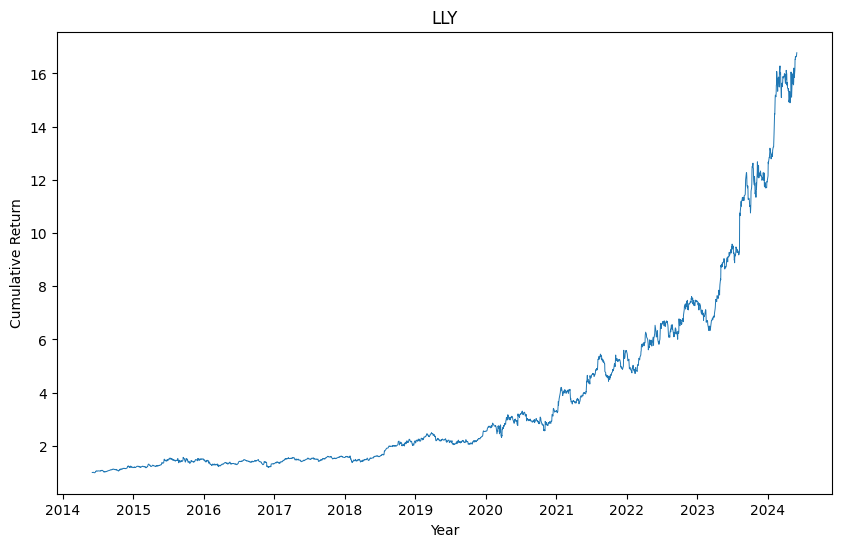

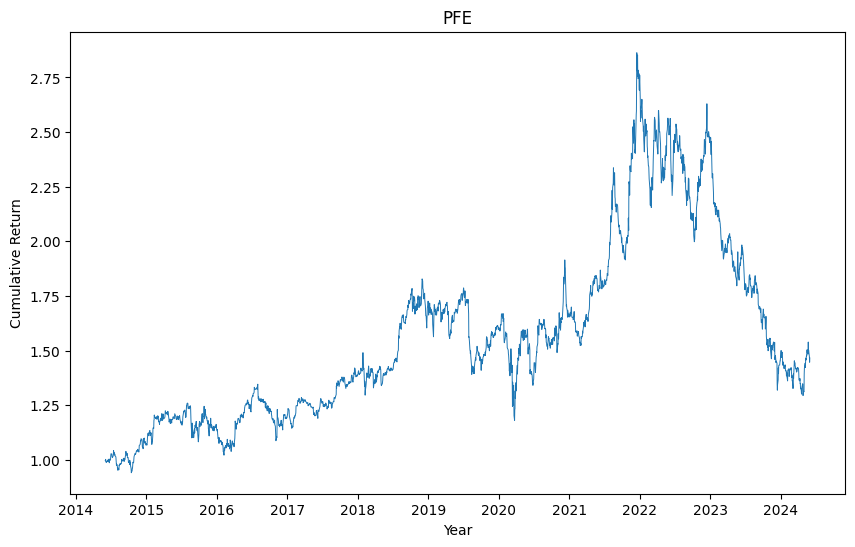

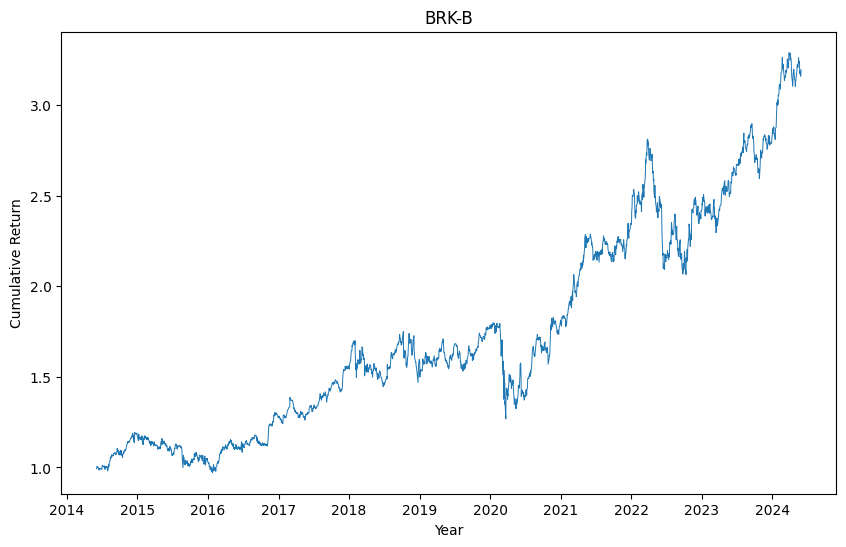

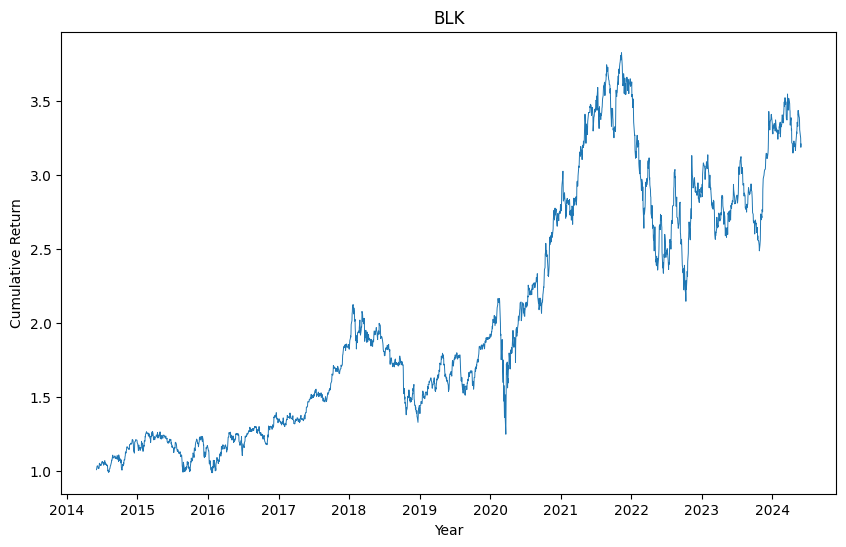

In [11]:
for ticker in selected_stocks:
    plt.figure(figsize=(10, 6))
    plt.plot(cumulative_returns[ticker], linewidth=0.7)
    plt.ylabel('Cumulative Return')
    plt.xlabel('Year')
    plt.title(ticker)
    plt.show()

#### Calcolo i rendimenti composti annui

In [12]:
annual_logarithmic_returns = np.log(annual_mean_adj_close / annual_mean_adj_close.shift(1))
annual_logarithmic_returns.dropna(inplace=True)
annual_logarithmic_returns

Ticker          AVGO       BLK     BRK-B       LLY      NVDA       PFE
Date                                                                  
2015-12-31  0.436897  0.071098  0.021573  0.219661  0.228249  0.147835
2016-12-31  0.237190  0.034775  0.027320 -0.005471  0.832395  0.008661
2017-12-31  0.425109  0.215937  0.195258  0.099625  1.030057  0.075622
2018-12-31  0.044281  0.172233  0.150505  0.157014  0.441813  0.176448
2019-12-31  0.225337 -0.065386  0.022084  0.240586 -0.282229  0.053604
2020-12-31  0.158157  0.249153 -0.014826  0.265549  0.820894 -0.041021
2021-12-31  0.462506  0.437091  0.285351  0.430090  0.681123  0.228561
2022-12-31  0.119425 -0.184594  0.110225  0.328184 -0.049408  0.199031
2023-12-31  0.400170  0.035327  0.096150  0.424518  0.678593 -0.264781
2024-12-31  0.502737  0.155358  0.175223  0.463164  0.782303 -0.253682

#### Mostro le informazioni sui rendimenti logaritmici

In [13]:
logarithmic_returns.describe()

Ticker         AVGO          BLK        BRK-B          LLY         NVDA  \
count   2516.000000  2516.000000  2516.000000  2516.000000  2516.000000   
mean       0.001280     0.000463     0.000462     0.001121     0.002187   
std        0.022179     0.017147     0.012110     0.016901     0.029572   
min       -0.222056    -0.146815    -0.100838    -0.111094    -0.207712   
25%       -0.009964    -0.007751    -0.005321    -0.006760    -0.011691   
50%        0.001316     0.000779     0.000481     0.000961     0.002388   
75%        0.012688     0.008739     0.006540     0.008839     0.016814   
max        0.146985     0.126843     0.109840     0.145656     0.260877   

Ticker          PFE  
count   2516.000000  
mean       0.000152  
std        0.014355  
min       -0.080502  
25%       -0.006726  
50%        0.000000  
75%        0.007011  
max        0.103055

#### Mostro le informazioni sui rendimenti semplici

In [14]:
adjusted_close_returns.describe()

Ticker         AVGO          BLK        BRK-B          LLY         NVDA  \
count   2516.000000  2516.000000  2516.000000  2516.000000  2516.000000   
mean       0.001526     0.000610     0.000535     0.001265     0.002629   
std        0.022139     0.017148     0.012104     0.017044     0.029824   
min       -0.199129    -0.136546    -0.095921    -0.105146    -0.187559   
25%       -0.009914    -0.007721    -0.005307    -0.006737    -0.011623   
50%        0.001317     0.000779     0.000481     0.000962     0.002391   
75%        0.012768     0.008777     0.006561     0.008879     0.016956   
max        0.158337     0.135239     0.116099     0.156798     0.298068   

Ticker          PFE  
count   2516.000000  
mean       0.000255  
std        0.014380  
min       -0.077347  
25%       -0.006703  
50%        0.000000  
75%        0.007036  
max        0.108552

#### Mostro un istogramma dei rendimenti logaritmici

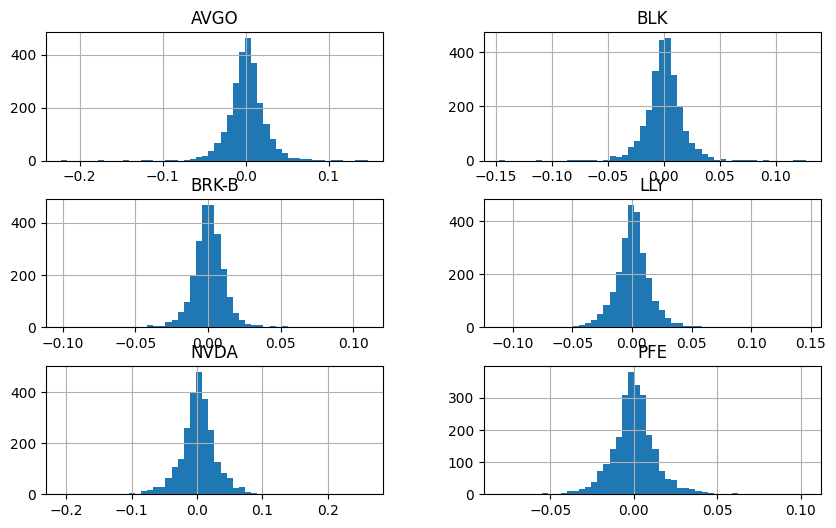

In [15]:
logarithmic_returns.hist(bins=50, figsize=(10, 6))
plt.show()

#### Mostro un grafico a dispersione dei rendimenti logaritmici dei titoli tecnologici
- Broadcom: AVGO
- Nvidia: NVDA

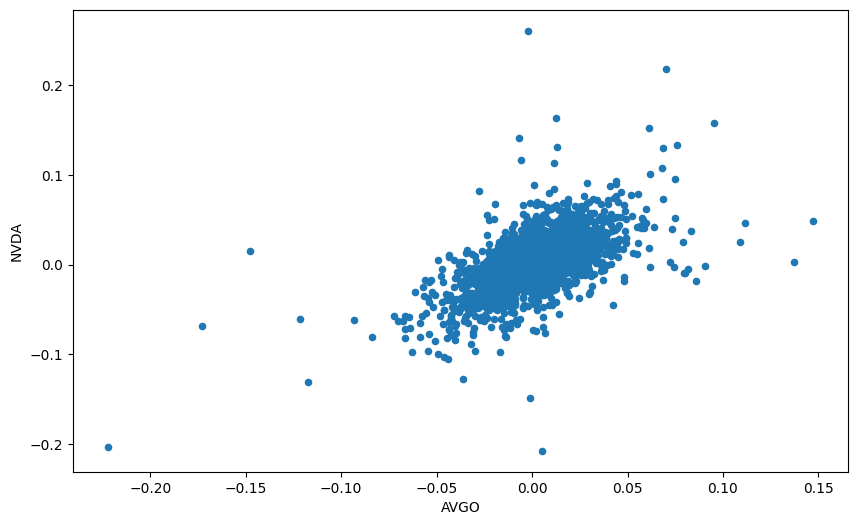

In [16]:
logarithmic_returns.plot(kind='scatter', x='AVGO', y='NVDA', figsize=(10, 6))
plt.show()

#### Mostro un grafico a dispersione dei rendimenti logaritmici dei titoli sanitari
- Eli Lilly: LLY
- Pfizer: PFE

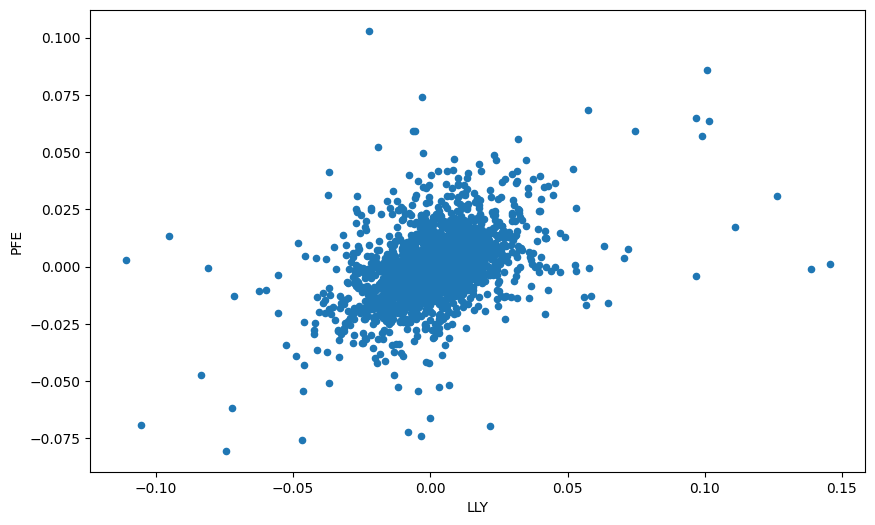

In [17]:
logarithmic_returns.plot(kind='scatter', x='LLY', y='PFE', figsize=(10, 6))
plt.show()

#### Mostro un grafico a dispersione dei rendimenti logaritmici dei titoli finanziari
- Berkshire Hathaway: BRK-B
- Blackrock: BLK

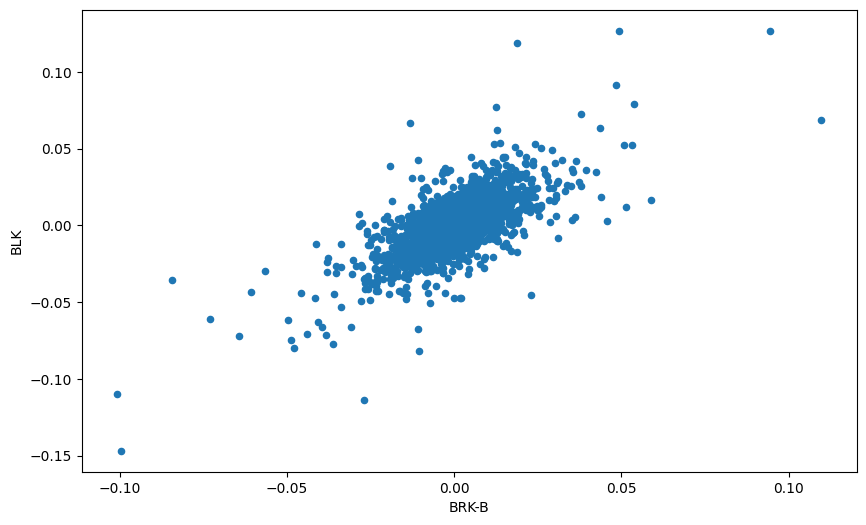

In [18]:
logarithmic_returns.plot(kind='scatter', x='BRK-B', y='BLK', figsize=(10, 6))
plt.show()

#### Mostro i grafici a densita dei rendimenti logaritmici per titolo

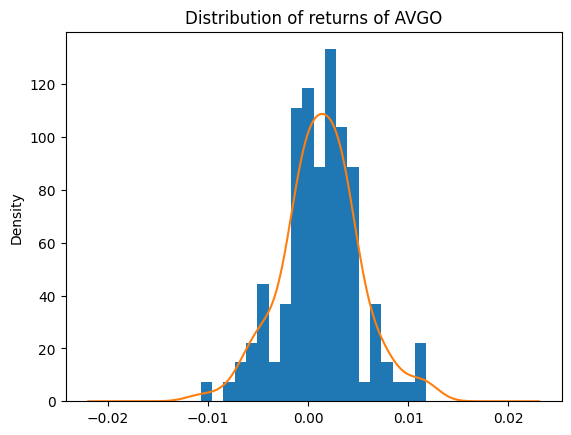

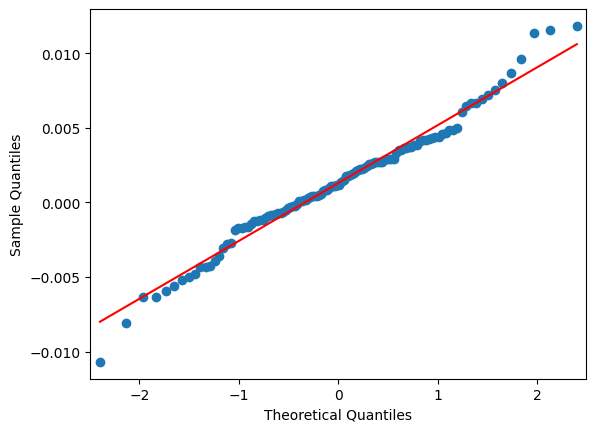

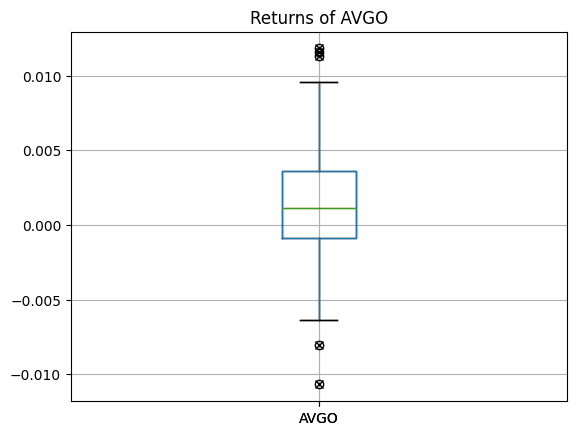

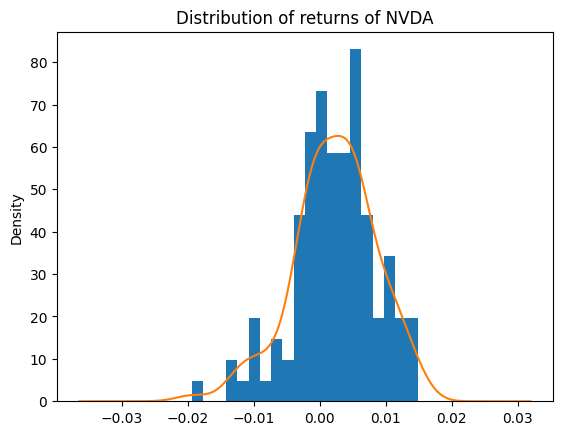

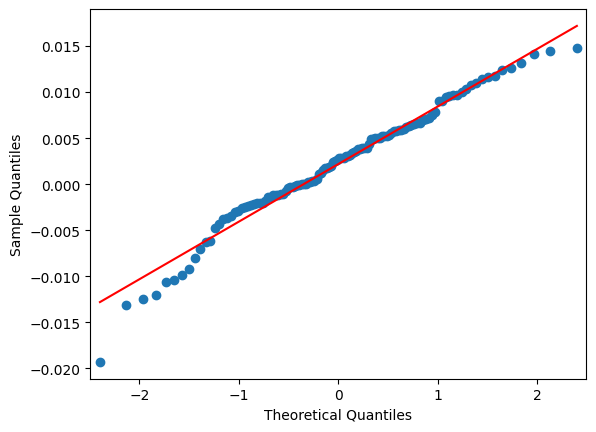

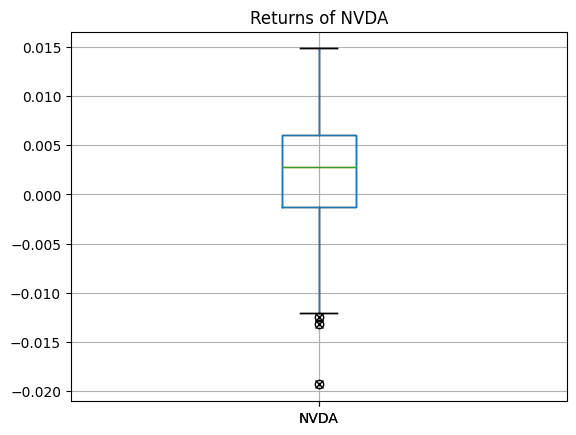

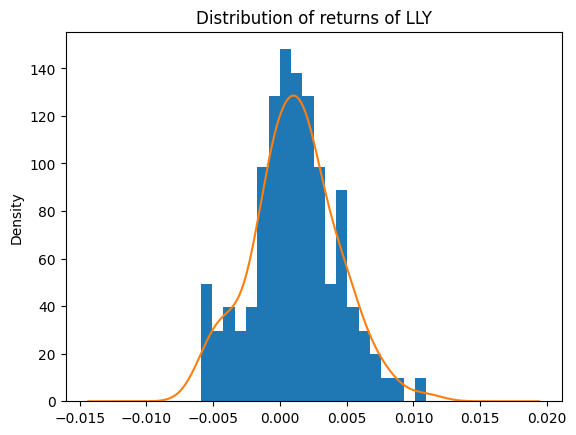

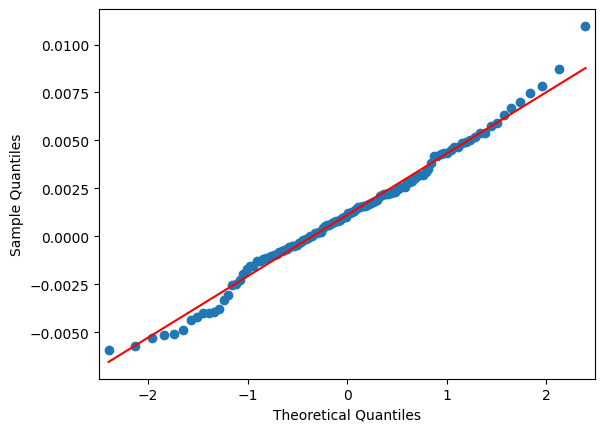

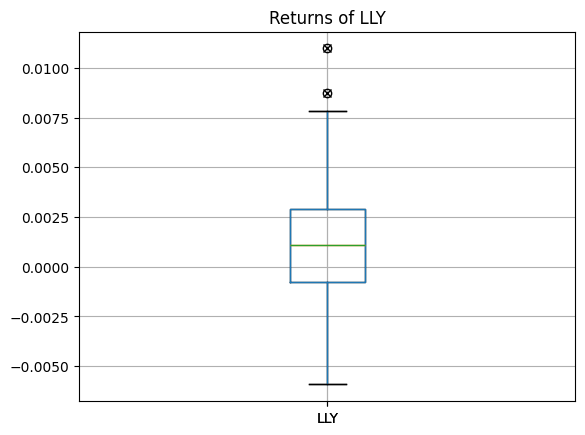

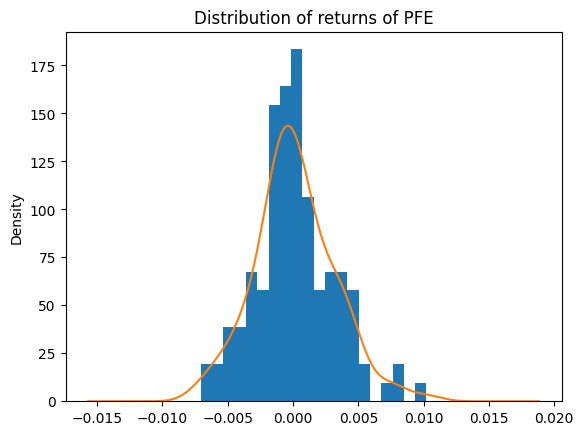

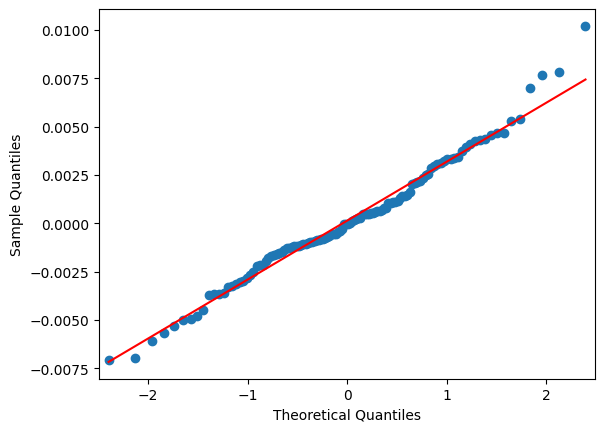

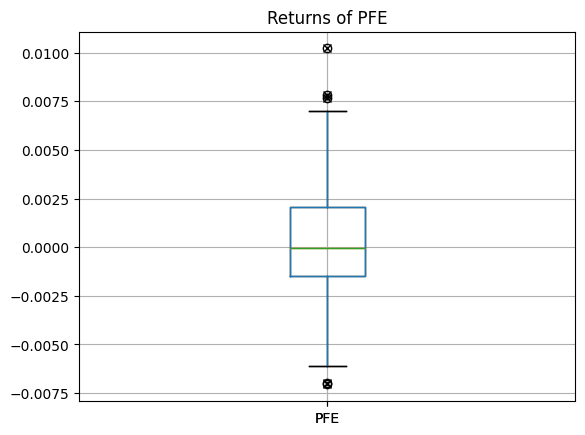

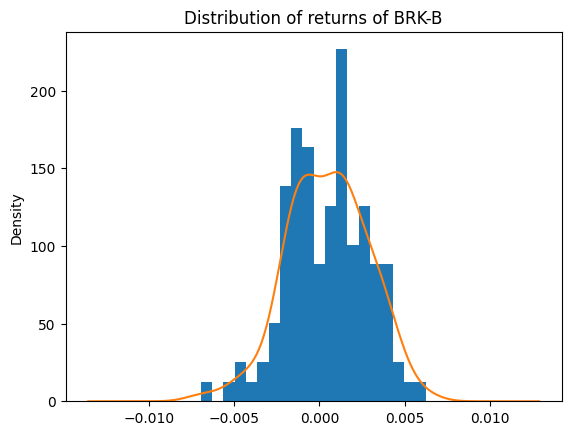

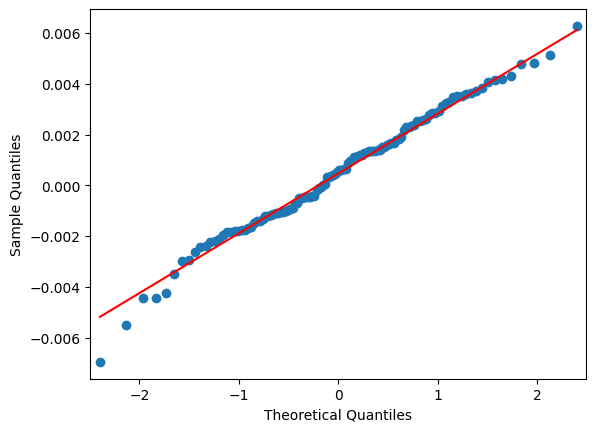

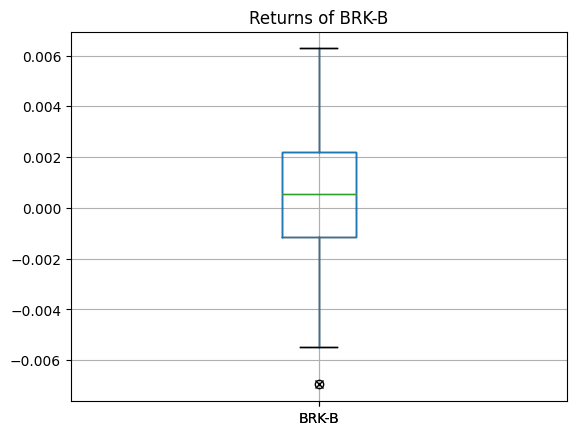

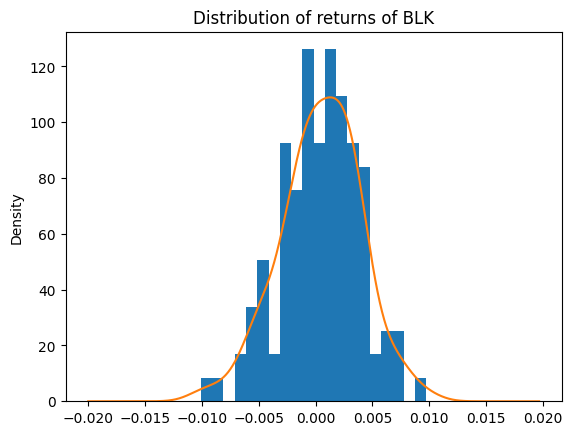

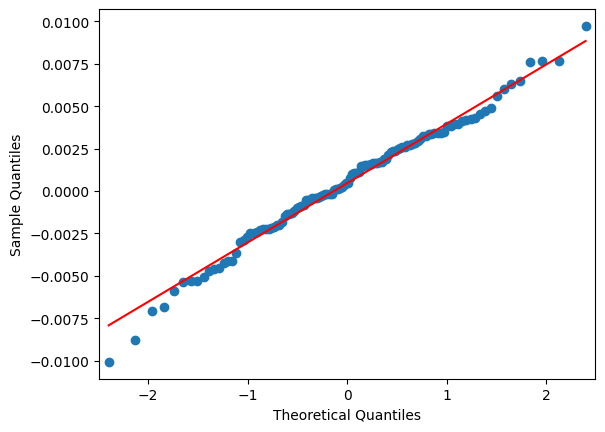

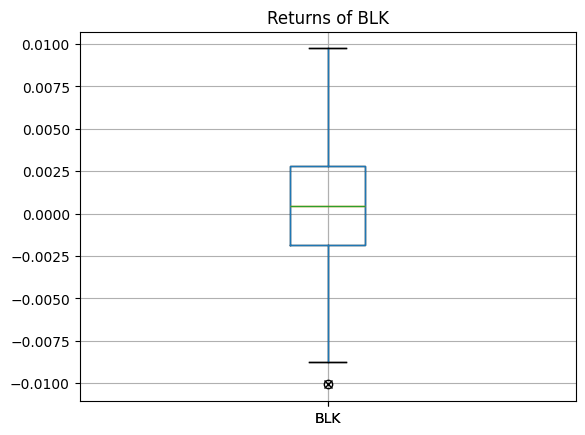

In [19]:
for ticker in selected_stocks:
    plt.figure()
    plt.hist(monthly_mean_logarithmic_returns[ticker], density = True, bins=20)
    plt.title('Distribution of returns of {}'.format(ticker))
    monthly_mean_logarithmic_returns[ticker].plot.density()

    sm.qqplot(monthly_mean_logarithmic_returns[ticker], line = 's')

    plt.figure()
    plt.boxplot(monthly_mean_logarithmic_returns[ticker], sym = 'x')
    plt.title('Returns of {}'.format(ticker))
    monthly_mean_logarithmic_returns[ticker].to_frame().boxplot()

plt.show()

#### Calcolo le statistiche descrittive univariate
- Media
- Varianza
- Deviazione Standard
- Asimmetria
- Curtosi

In [20]:
for ticker in selected_stocks:
    mean_return = round(logarithmic_returns[ticker].mean(), 4)
    variance_return = round(logarithmic_returns[ticker].var(), 4)
    std_deviation_return = round(logarithmic_returns[ticker].std(), 4)
    skewness_return = round(logarithmic_returns[ticker].skew(), 4)
    kurtosis_return = round(logarithmic_returns[ticker].kurtosis(), 4)
    
    print(f"Ticker: {ticker}")
    print(f"Average: {mean_return}")
    print(f"Variance: {variance_return}")
    print(f"Standard Deviation: {std_deviation_return}")
    print(f"Skew: {skewness_return}")
    print(f"Kurtosis: {kurtosis_return}")
    print()

Ticker: AVGO
Average: 0.0013
Variance: 0.0005
Standard Deviation: 0.0222
Skew: -0.4277
Kurtosis: 9.3448

Ticker: NVDA
Average: 0.0022
Variance: 0.0009
Standard Deviation: 0.0296
Skew: 0.2482
Kurtosis: 7.6319

Ticker: LLY
Average: 0.0011
Variance: 0.0003
Standard Deviation: 0.0169
Skew: 0.7396
Kurtosis: 10.7269

Ticker: PFE
Average: 0.0002
Variance: 0.0002
Standard Deviation: 0.0144
Skew: 0.1503
Kurtosis: 5.1215

Ticker: BRK-B
Average: 0.0005
Variance: 0.0001
Standard Deviation: 0.0121
Skew: -0.2482
Kurtosis: 11.2449

Ticker: BLK
Average: 0.0005
Variance: 0.0003
Standard Deviation: 0.0171
Skew: -0.1606
Kurtosis: 8.7427



#### Calcolo la correlazione tra i rendimenti logaritmici dei titoli tecnologici

In [21]:
it_sector_correlation = logarithmic_returns['NVDA'].corr(logarithmic_returns['AVGO'])
print(f"IT Sector Correlation: {it_sector_correlation}")

IT Sector Correlation: 0.5955422179137635


#### Calcolo la correlazione tra i rendimenti logaritmici dei titoli sanitari

In [22]:
healthcare_sector_correlation = logarithmic_returns['PFE'].corr(logarithmic_returns['LLY'])
print(f"Healthcare Sector Correlation: {healthcare_sector_correlation}")

Healthcare Sector Correlation: 0.43407909326809635


#### Calcolo la correlazione tra i rendimenti logaritmici dei titoli finanziari

In [23]:
finance_sector_correlation = logarithmic_returns['BLK'].corr(logarithmic_returns['BRK-B'])
print(f"Finance Sector Correlation: {finance_sector_correlation}")

Finance Sector Correlation: 0.7064242764715777


#### Calcolo matrice di covarianza

In [24]:
covariance_matrix = logarithmic_returns.cov()
print(covariance_matrix)

Ticker      AVGO       BLK     BRK-B       LLY      NVDA       PFE
Ticker                                                            
AVGO    0.000492  0.000207  0.000130  0.000094  0.000391  0.000081
BLK     0.000207  0.000294  0.000147  0.000094  0.000251  0.000099
BRK-B   0.000130  0.000147  0.000147  0.000076  0.000142  0.000081
LLY     0.000094  0.000094  0.000076  0.000286  0.000115  0.000105
NVDA    0.000391  0.000251  0.000142  0.000115  0.000874  0.000082
PFE     0.000081  0.000099  0.000081  0.000105  0.000082  0.000206


#### Calcolo matrice di correlazione

In [25]:
correlation_matrix = logarithmic_returns.corr()
print(correlation_matrix)

Ticker      AVGO       BLK     BRK-B       LLY      NVDA       PFE
Ticker                                                            
AVGO    1.000000  0.543172  0.485652  0.251777  0.595542  0.255830
BLK     0.543172  1.000000  0.706424  0.325221  0.495117  0.403830
BRK-B   0.485652  0.706424  1.000000  0.368904  0.396326  0.463404
LLY     0.251777  0.325221  0.368904  1.000000  0.229231  0.434079
NVDA    0.595542  0.495117  0.396326  0.229231  1.000000  0.192428
PFE     0.255830  0.403830  0.463404  0.434079  0.192428  1.000000


#### Calcolo correlazione nel tempo per ogni settore

In [26]:
it_sector_correlation_over_time = logarithmic_returns['NVDA'].rolling(window=90).corr(logarithmic_returns['AVGO'])
healthcare_sector_correlation_over_time = logarithmic_returns['PFE'].rolling(window=90).corr(logarithmic_returns['LLY'])
finance_sector_correlation_over_time = logarithmic_returns['BLK'].rolling(window=90).corr(logarithmic_returns['BRK-B'])

#### Mostro grafico correlazione nel tempo per il settore tecnologico

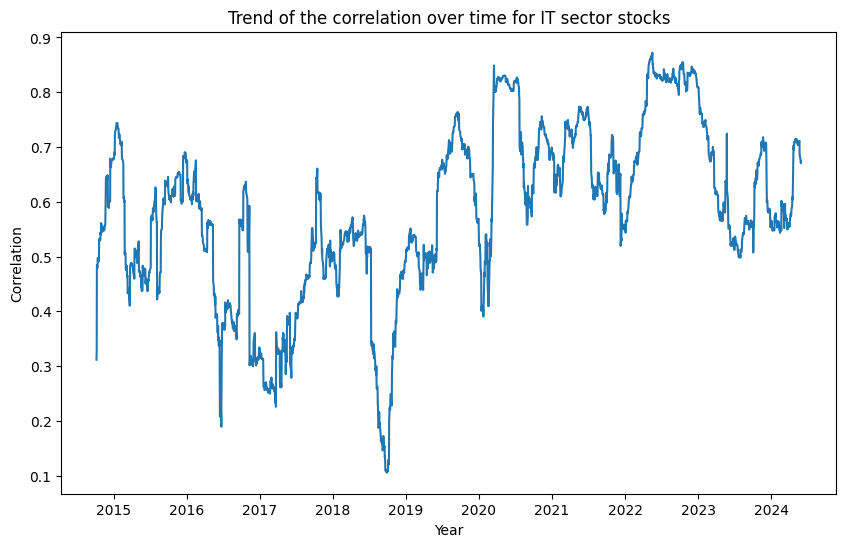

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(it_sector_correlation_over_time.index, it_sector_correlation_over_time)
ax.set_xlabel('Year')
ax.set_ylabel('Correlation')
ax.set_title('Trend of the correlation over time for IT sector stocks')
plt.show()

#### Mostro grafico correlazione nel tempo per il settore sanitario

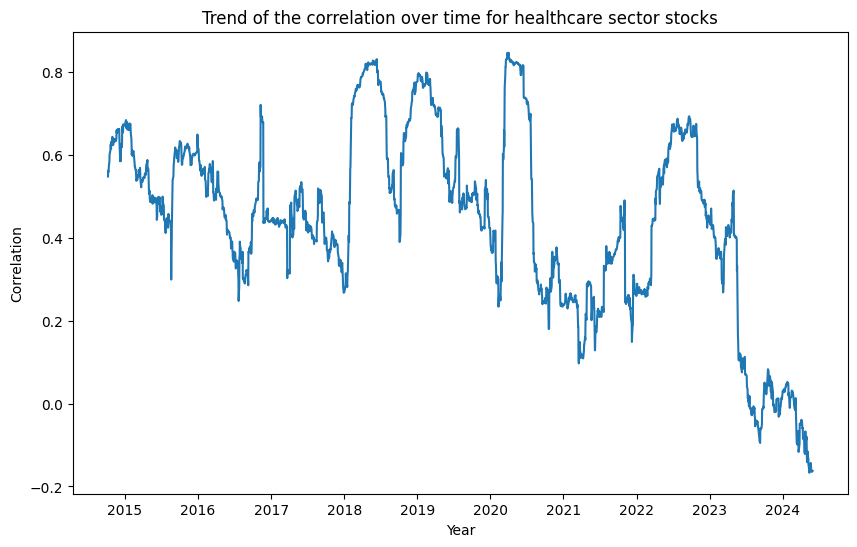

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(healthcare_sector_correlation_over_time.index, healthcare_sector_correlation_over_time)
ax.set_xlabel('Year')
ax.set_ylabel('Correlation')
ax.set_title('Trend of the correlation over time for healthcare sector stocks')
plt.show()

#### Mostro grafico correlazione nel tempo per il settore bancario

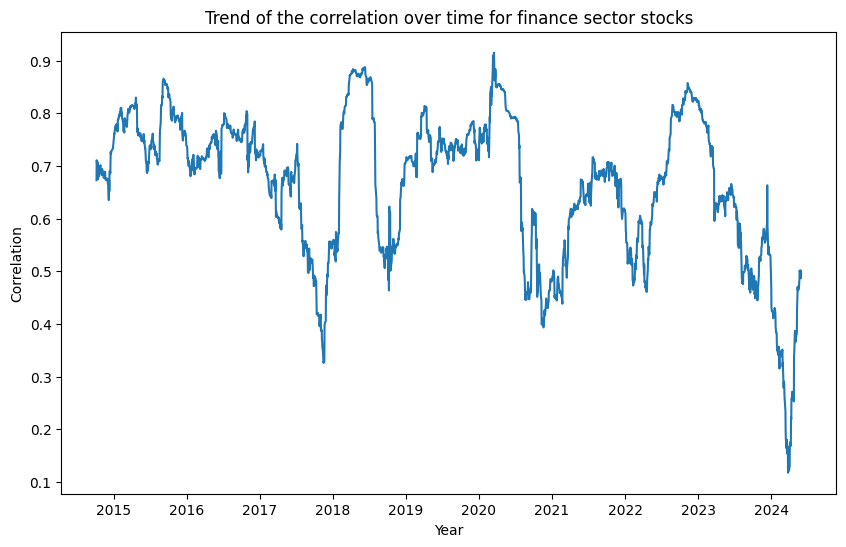

In [29]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(finance_sector_correlation_over_time.index, finance_sector_correlation_over_time)
ax.set_xlabel('Year')
ax.set_ylabel('Correlation')
ax.set_title('Trend of the correlation over time for finance sector stocks')
plt.show()

#### Calcolo delle correlazione medie

In [30]:
mean_correlation = correlation_matrix.mean()

#### Mostro il grafico di dispersione delle correlazione medie tra i titoli tecnologici

Text(0, 0.5, 'NVDA')

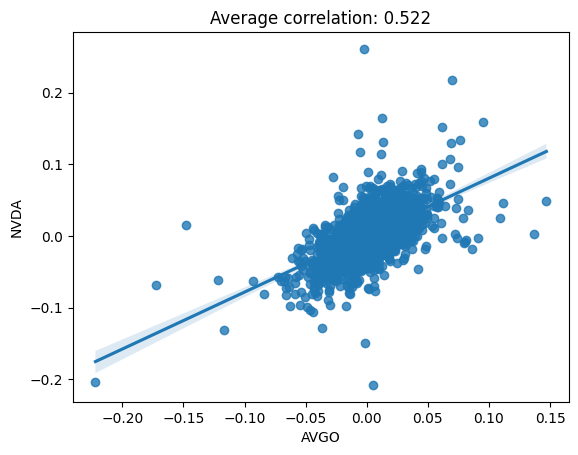

In [31]:
plt.figure()
sns.regplot(x=logarithmic_returns['AVGO'], y=logarithmic_returns['NVDA'], data=logarithmic_returns)
plt.title("Average correlation: " + str(round(mean_correlation['AVGO'], 4)))
plt.xlabel('AVGO')
plt.ylabel('NVDA')

#### Mostro il grafico di dispersione delle correlazione medie tra i titoli sanitari

Text(0, 0.5, 'PFE')

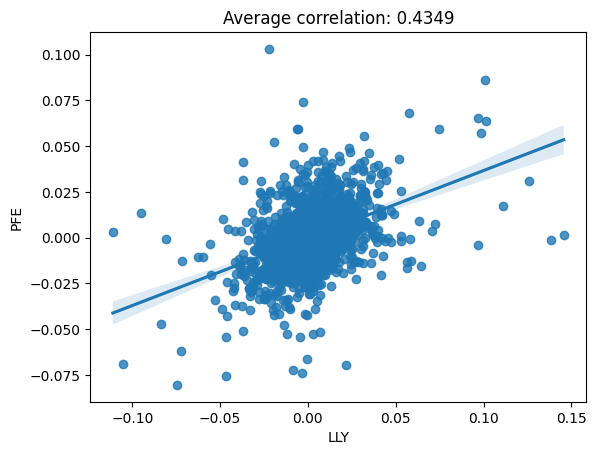

In [32]:
plt.figure()
sns.regplot(x=logarithmic_returns['LLY'], y=logarithmic_returns['PFE'], data=logarithmic_returns)
plt.title("Average correlation: " + str(round(mean_correlation['LLY'], 4)))
plt.xlabel('LLY')
plt.ylabel('PFE')

#### Mostro il grafico di dispersione delle correlazione medie tra i titoli bancari

Text(0, 0.5, 'BLK')

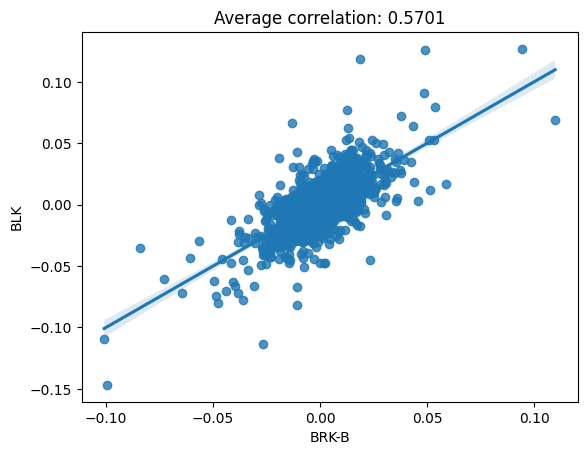

In [33]:
plt.figure()
sns.regplot(x=logarithmic_returns['BRK-B'], y=logarithmic_returns['BLK'], data=logarithmic_returns)
plt.title("Average correlation: " + str(round(mean_correlation['BRK-B'], 4)))
plt.xlabel('BRK-B')
plt.ylabel('BLK')

#### Calcolo il forecast a 5 giorni

In [34]:
forecast_days = 5
for ticker in selected_stocks:
    column_position = adj_close_data.columns.get_loc(ticker) + 1
    adj_close_data.insert(
        column_position,
        f"{ticker}_5_Days_Price_Forecast",
        adj_close_data[ticker].shift(-forecast_days)
    )

print(adj_close_data.head(12))

Ticker           AVGO  AVGO_5_Days_Price_Forecast         BLK  \
Date                                                            
2014-06-02  54.481525                   54.595608  237.437592   
2014-06-03  54.337040                   54.648834  239.439163   
2014-06-04  54.458725                   54.565182  241.099609   
2014-06-05  54.656433                   54.572792  241.966187   
2014-06-06  54.473923                   54.314220  245.112411   
2014-06-09  54.595608                   53.903564  245.588623   
2014-06-10  54.648834                   54.583183  245.690155   
2014-06-11  54.565182                   54.384640  243.106033   
2014-06-12  54.572792                   54.163189  241.099609   
2014-06-13  54.314220                   54.651901  241.591461   
2014-06-16  53.903564                   54.399899  241.536835   
2014-06-17  54.583183                   53.964642  243.621307   

Ticker      BLK_5_Days_Price_Forecast       BRK-B  \
Date                                

#### Divido il dataset in base ai titoli

In [35]:
adj_close_forecasts = [
    adj_close_data[[ticker, f"{ticker}_5_Days_Price_Forecast"]]
    for ticker in selected_stocks
]

print(adj_close_forecasts)

[Ticker             AVGO  AVGO_5_Days_Price_Forecast
Date                                               
2014-06-02    54.481525                   54.595608
2014-06-03    54.337040                   54.648834
2014-06-04    54.458725                   54.565182
2014-06-05    54.656433                   54.572792
2014-06-06    54.473923                   54.314220
...                 ...                         ...
2024-05-23  1393.290039                         NaN
2024-05-24  1407.839966                         NaN
2024-05-28  1412.449951                         NaN
2024-05-29  1390.670044                         NaN
2024-05-30  1364.079956                         NaN

[2517 rows x 2 columns], Ticker             NVDA  NVDA_5_Days_Price_Forecast
Date                                               
2014-06-02     4.507795                    4.533977
2014-06-03     4.488754                    4.557775
2014-06-04     4.493515                    4.617277
2014-06-05     4.512555              

#### Ritorno la forma dell'array (numero di elementi in ogni dimensione)

In [36]:
print(adj_close_forecasts[0].shape)

(2517, 2)


#### Analisi e grafico per ogni titolo del dataset

[*********************100%%**********************]  6 of 6 completed


SVM model confidence score for AVGO: 0.9309353090216329
Mean Absolute Error for AVGO: 17.09846227353886
Mean Squared Error for AVGO: 468.5016996274481
R2 Score for AVGO: 0.9020052796754349
0.9309353090216329


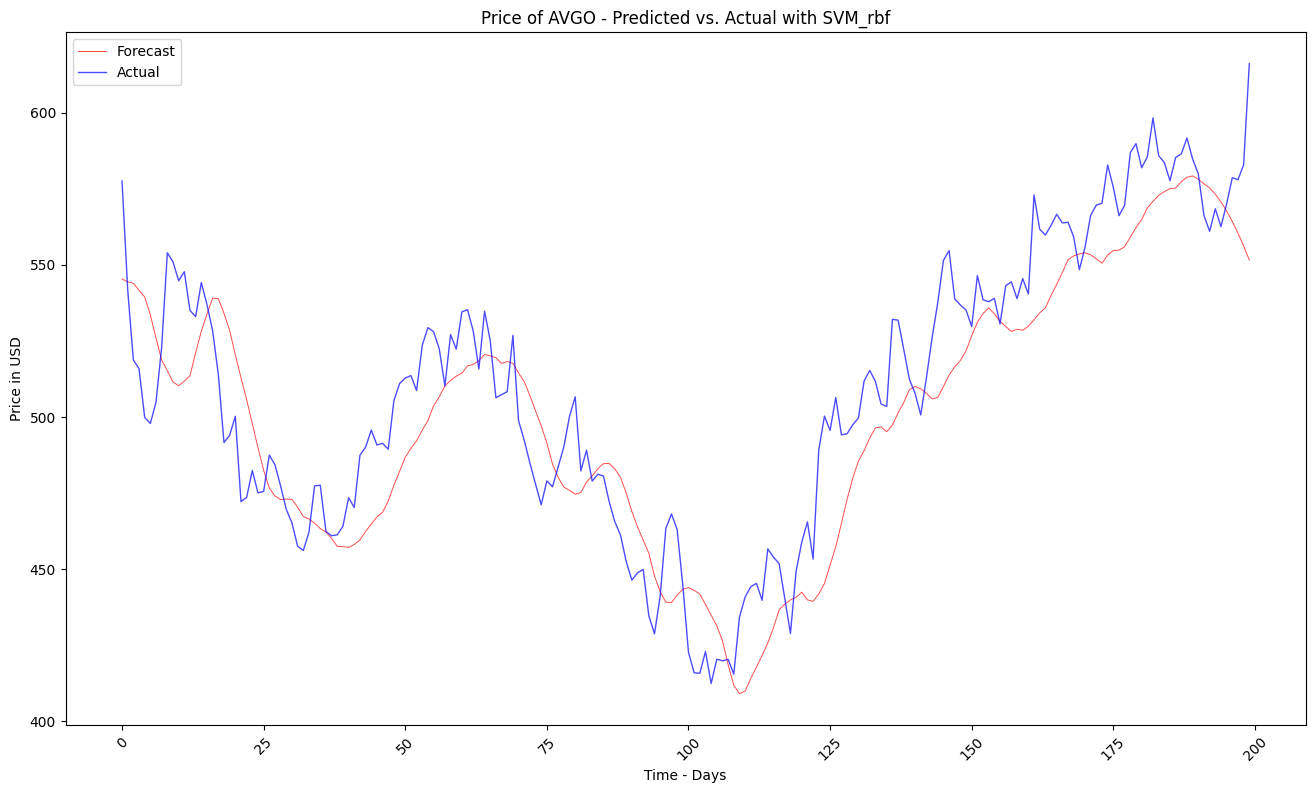

SVM model confidence score for NVDA: 0.9356518281265356
Mean Absolute Error for NVDA: 10.697310429371619
Mean Squared Error for NVDA: 204.273242039776
R2 Score for NVDA: 0.9242129610527732
0.9356518281265356


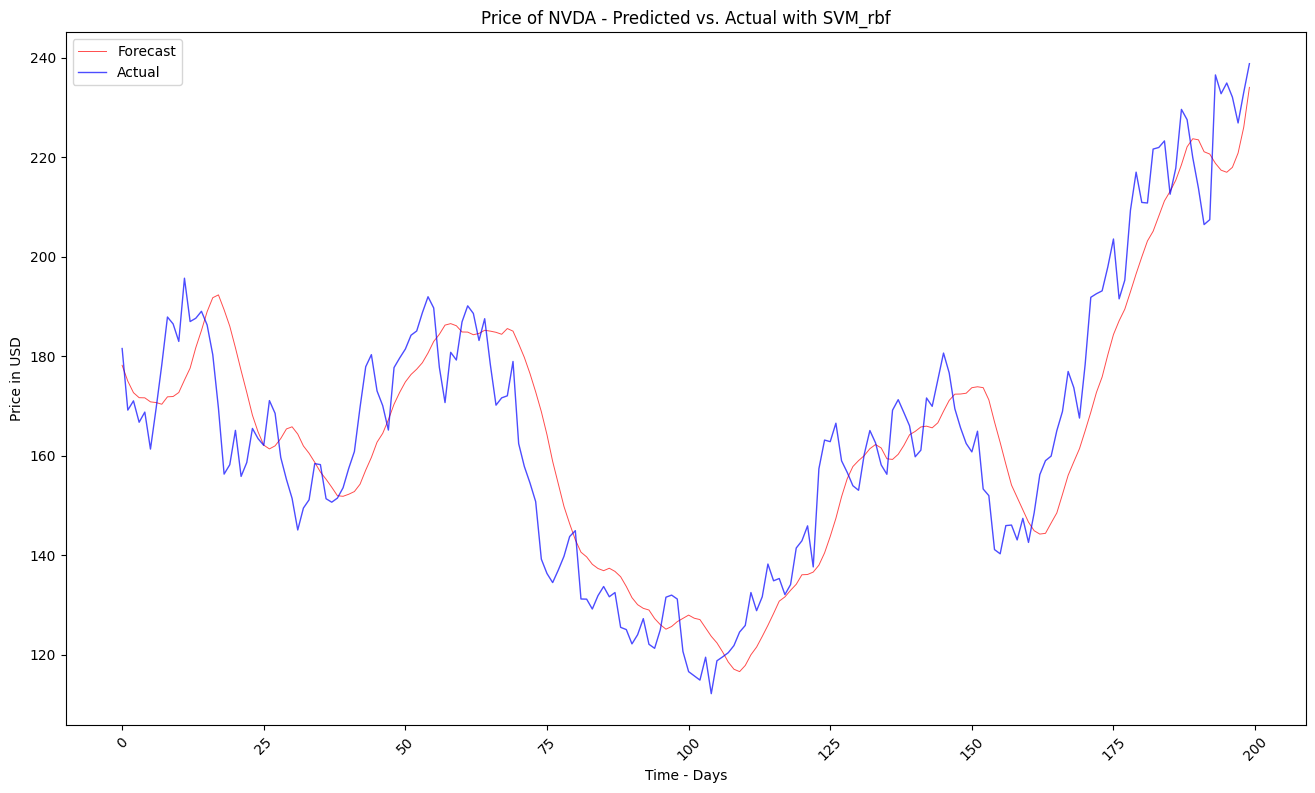

SVM model confidence score for LLY: 0.9203067142678144
Mean Absolute Error for LLY: 8.295257863756062
Mean Squared Error for LLY: 115.4992953584922
R2 Score for LLY: 0.9720334239741667
0.9203067142678144


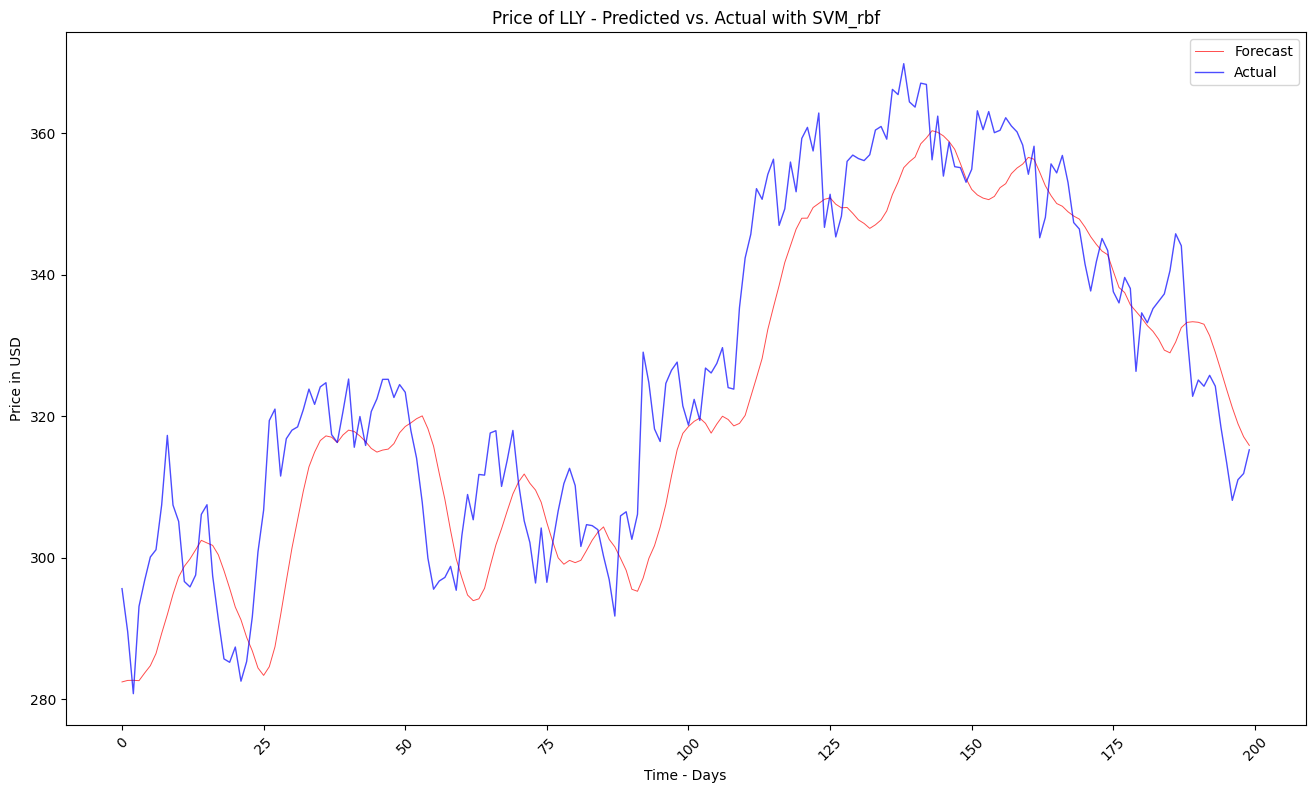

SVM model confidence score for PFE: 0.9453477170293748
Mean Absolute Error for PFE: 1.2343836426399157
Mean Squared Error for PFE: 2.7517754625420245
R2 Score for PFE: 0.9334185099439416
0.9453477170293748


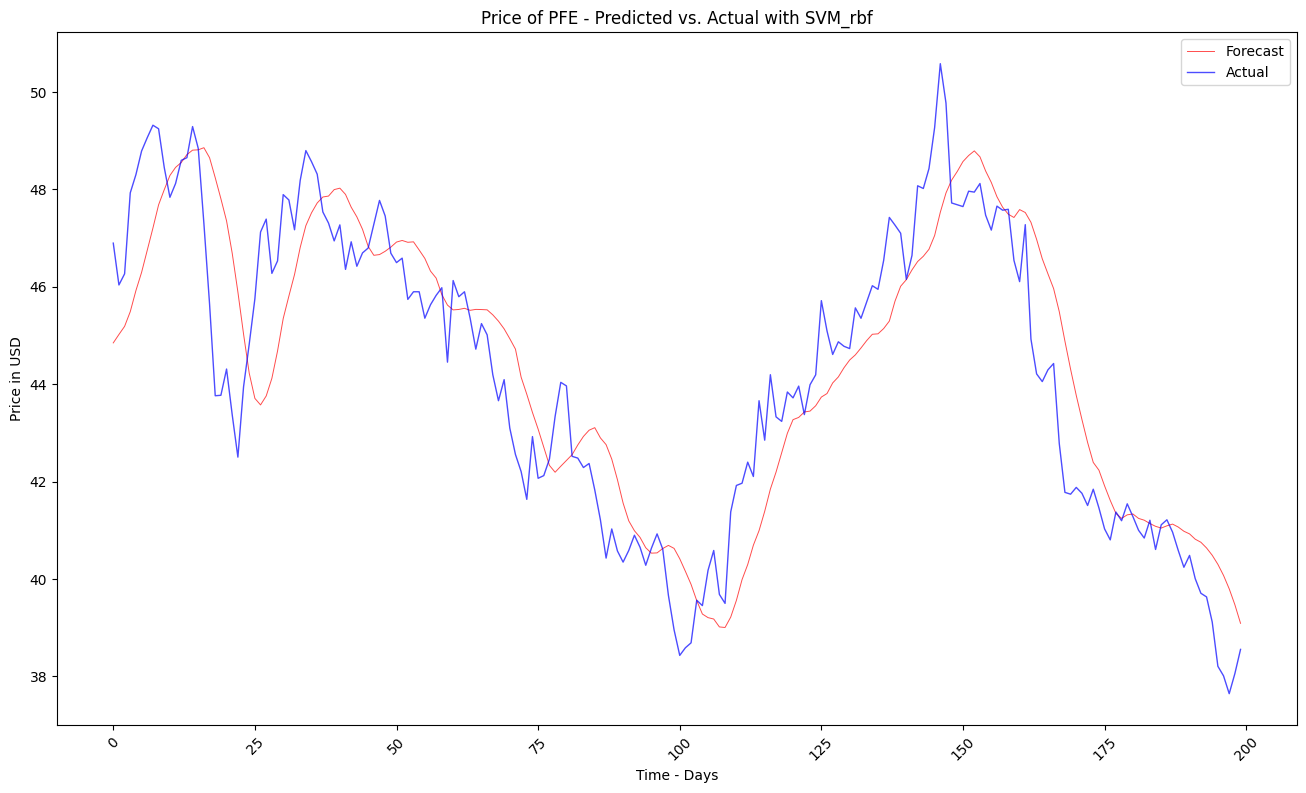

SVM model confidence score for BRK-B: 0.9418194634492808
Mean Absolute Error for BRK-B: 6.057625538634839
Mean Squared Error for BRK-B: 63.76416645169634
R2 Score for BRK-B: 0.9372949005767744
0.9418194634492808


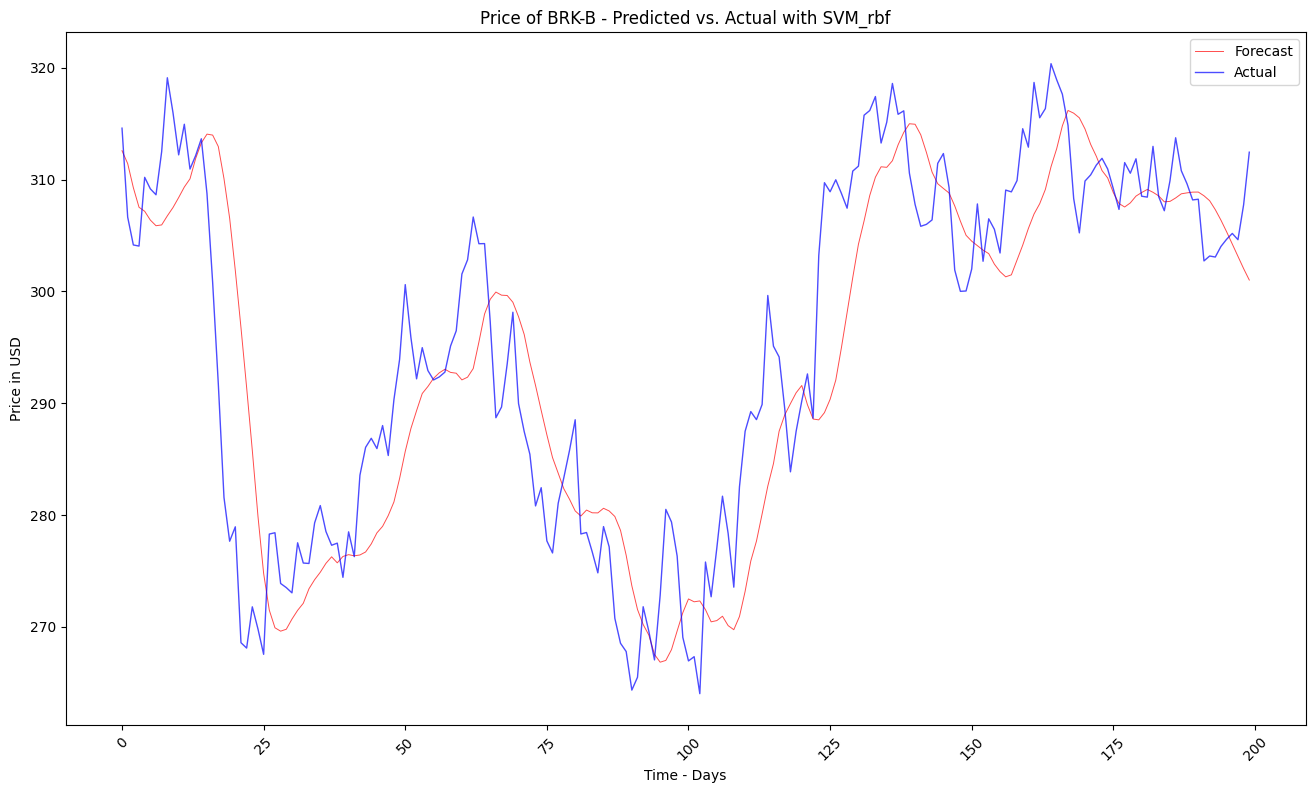

SVM model confidence score for BLK: 0.8629238266364584
Mean Absolute Error for BLK: 24.536944640346142
Mean Squared Error for BLK: 937.4870759300209
R2 Score for BLK: 0.8991363545899042
0.8629238266364584


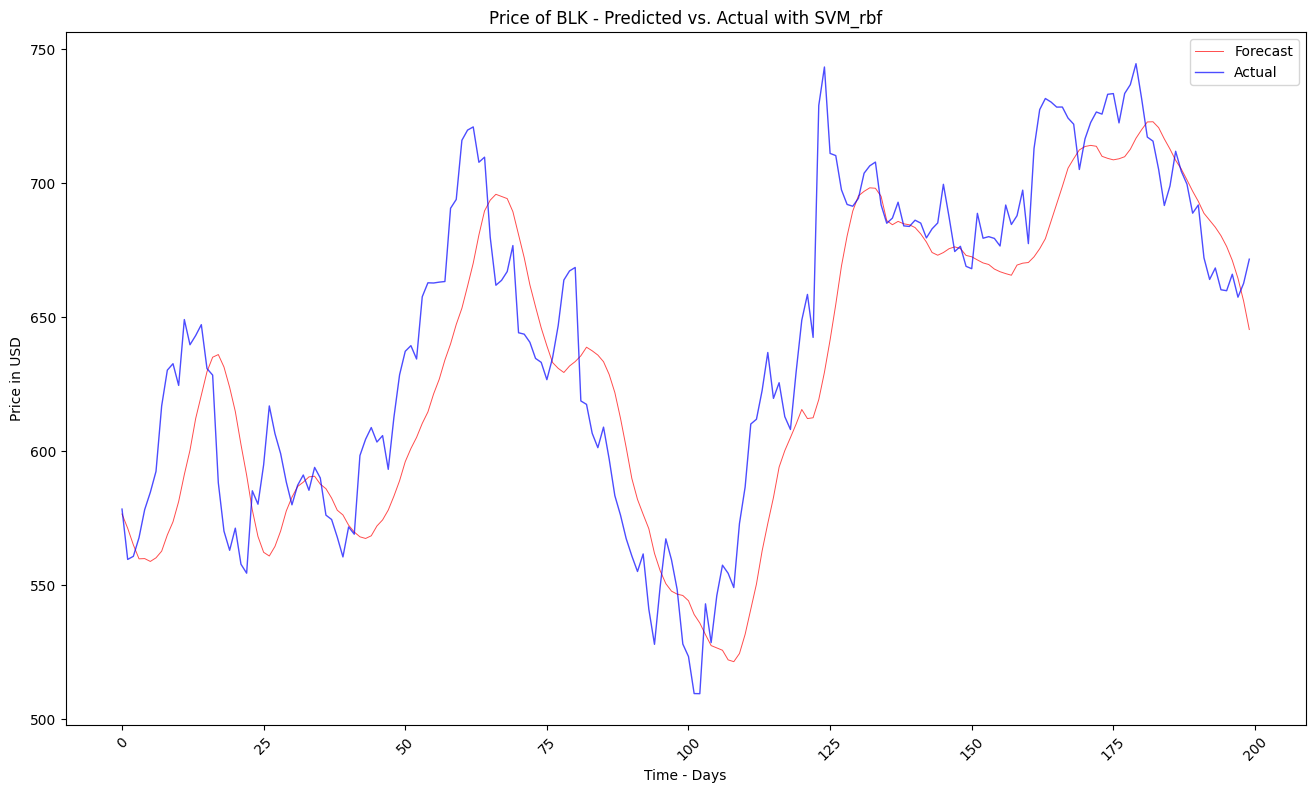

In [37]:
forecast_start_date = '2023-12-30'
forecast_end_date = '2024-10-29'
forecast_days = 5
stocks_data_prediction = yf.download(selected_stocks, start=forecast_start_date, end=forecast_end_date)

for df in adj_close_forecasts:

    feature_array = np.array(df.iloc[:, 0])
    feature_array = feature_array[:df.shape[0] - forecast_days]
    feature_array = np.reshape(feature_array, (-1, 1))
    
    target_array = np.array(df.iloc[:, 1])
    target_array = target_array[:-forecast_days]    

    #Divido i dati in set di training, validazione e test
    X_training = feature_array[:1600]
    y_training = target_array[:1600]
    X_validation = feature_array[1600:2200]
    y_validation = target_array[1600:2200]
    X_test = feature_array[2200:]
    y_test = target_array[2200:]

    #Standardizzazione dei dati
    scaler = StandardScaler()
    scaler.fit(X_training)
    x_training = scaler.transform(X_training)
    X_validation = scaler.transform(X_validation)
    X_test = scaler.transform(X_test)

    #Training del modello SVM
    svm_model = SVR(kernel='rbf', C = 1e3, gamma = 0.0001)
    svm_model.fit(x_training, y_training)

    #Valutazione del modello
    svm_model_confidence = svm_model.score(X_test, y_test)
    print(f'SVM model confidence score for {df.columns[0]}: {svm_model_confidence}')

    #Affinamento delle predizioni
    svm_predictions = svm_model.predict(X_test)
    svm_prediction_smooth = savgol_filter(svm_predictions, 15, 3)

    svm_val_predictions = svm_model.predict(X_validation)
    svm_val_predictions_smooth = savgol_filter(svm_val_predictions, 15, 3)

    #calcolo metriche di valutazione
    mae = mean_absolute_error(y_validation, svm_val_predictions)
    mse = mean_squared_error(y_validation, svm_val_predictions)
    r2 = r2_score(y_validation, svm_val_predictions)

    print(f'Mean Absolute Error for {df.columns[0]}: {mae}')
    print(f'Mean Squared Error for {df.columns[0]}: {mse}')
    print(f'R2 Score for {df.columns[0]}: {r2}')
    print(svm_model.score(X_test, y_test))

    #Grafico dei risultati
    plt.figure(figsize=(16,9))
    plt.plot(svm_val_predictions_smooth[400:], label = 'Forecast', linewidth = '0.7', color ='r', alpha = .7)
    plt.plot(y_validation[400:], label = 'Actual', linewidth = '1', color ='b', alpha = .7)
    plt.title('Price of ' f"{df.columns[0]}" ' - Predicted vs. Actual with SVM_rbf')
    plt.ylabel('Price in USD')
    plt.xlabel('Time - Days')
    plt.legend()
    plt.xticks(rotation = 45)
    plt.show()

#### Utilizzo stile ggplot

In [38]:
style.use('ggplot')

#### Creo un DataFrame per ogni ticker

In [39]:
stock_dataframes = {}

for ticker in selected_stocks:
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    stock_data = stock_data.drop(columns=['High', 'Low', 'Open', 'Close'])
    stock_dataframes[f"df_{ticker}"] = stock_data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


#### Creo le due serie mobili

In [40]:
for ticker in selected_stocks:
    dataframe_key = f"df_{ticker}"
    stock_dataframes[dataframe_key]['SMA20'] = stock_dataframes[dataframe_key]['Adj Close'].rolling(20).mean()
    stock_dataframes[dataframe_key]['SMA120'] = stock_dataframes[dataframe_key]['Adj Close'].rolling(120).mean()

#### Mostro un grafico per ogni azione

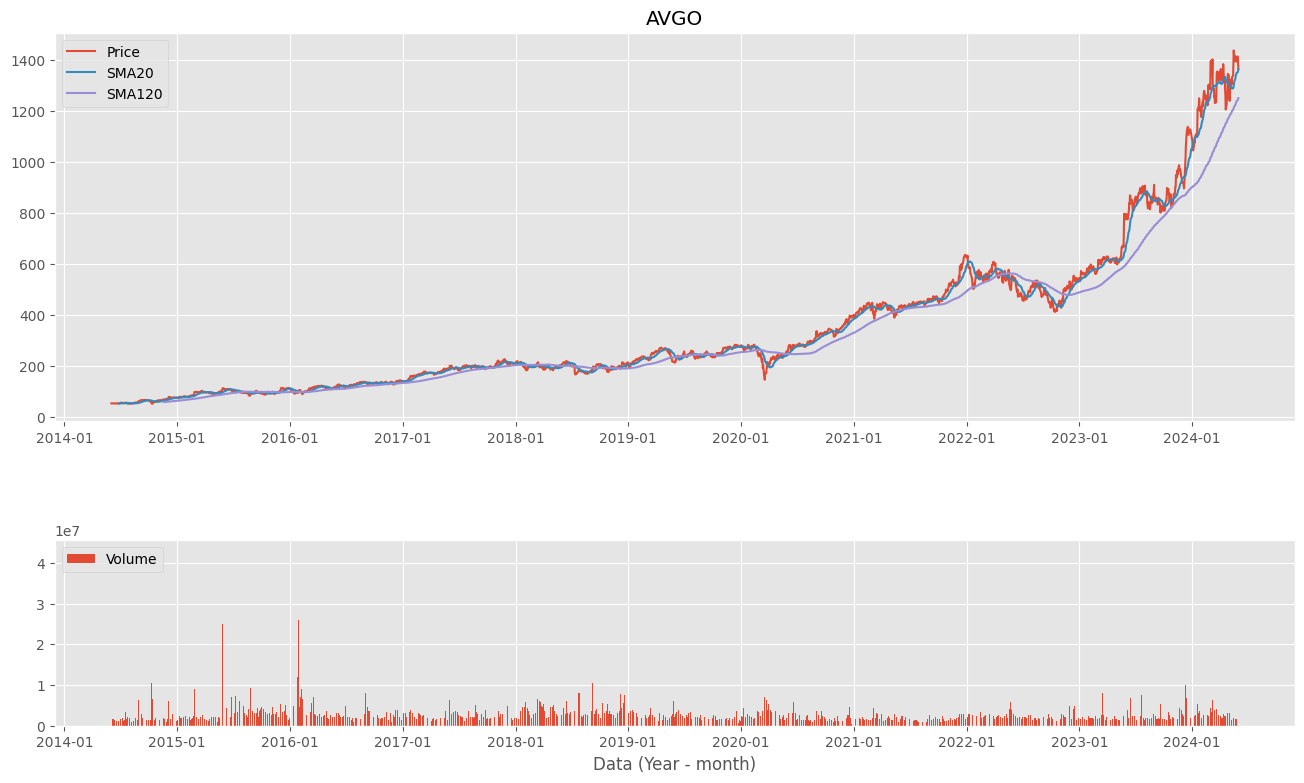

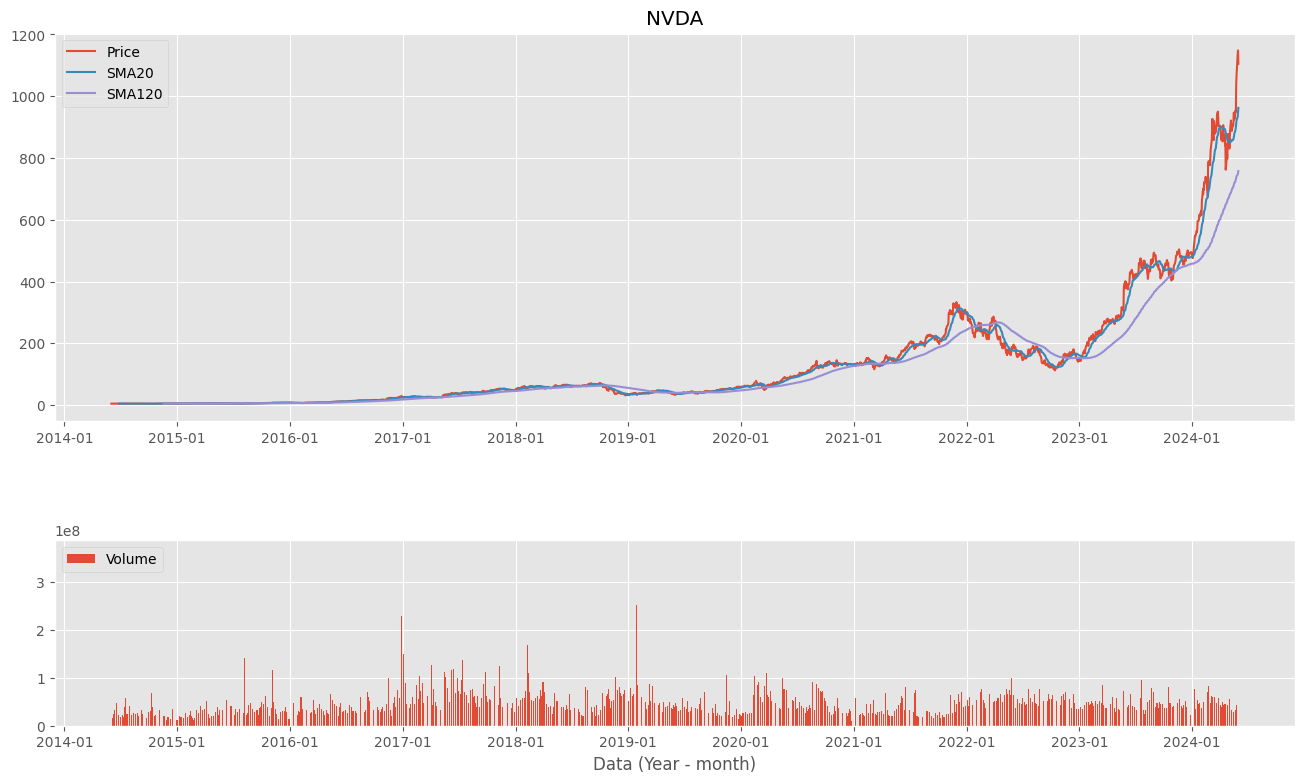

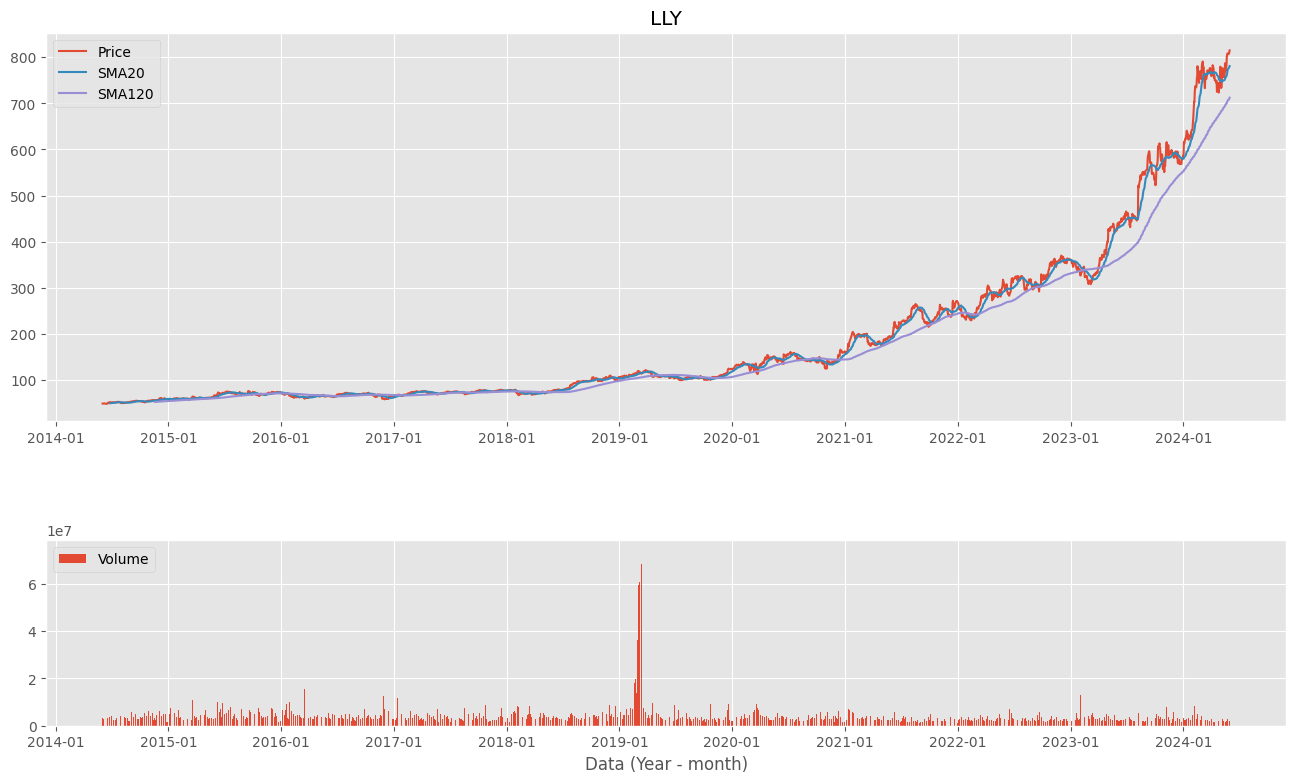

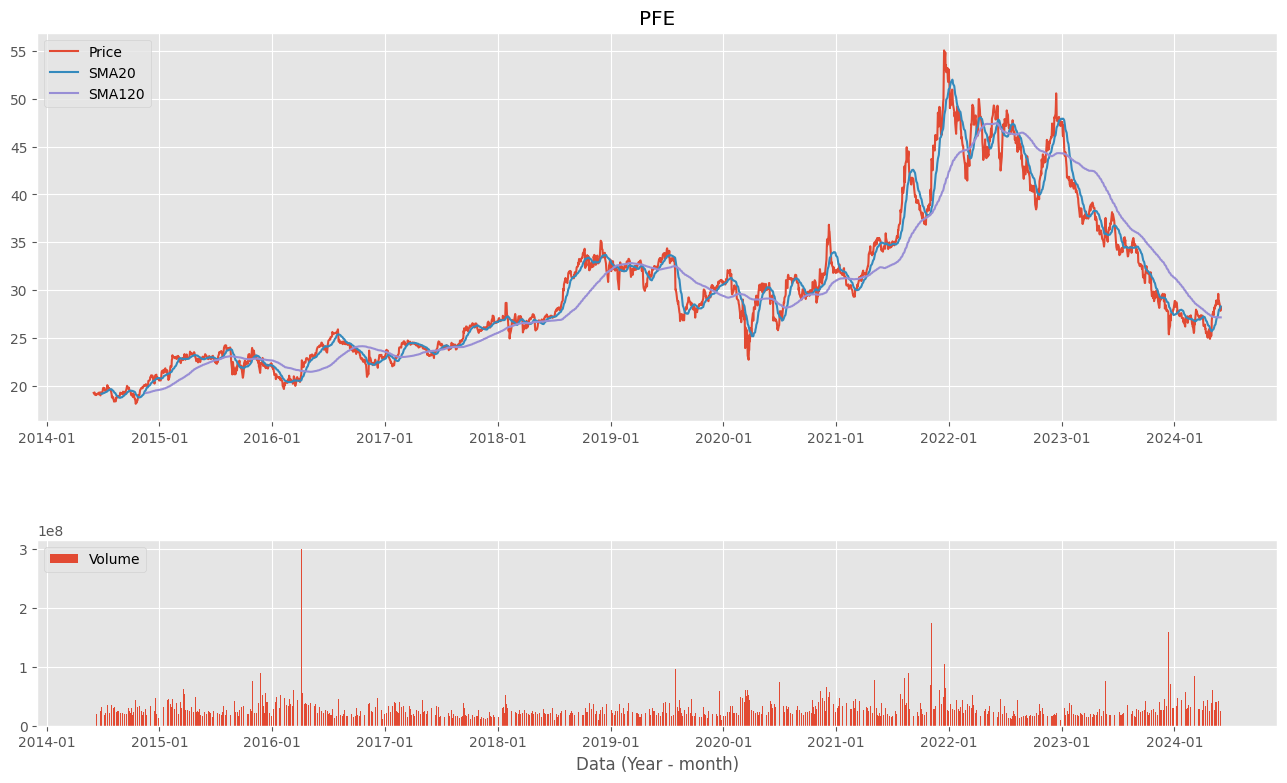

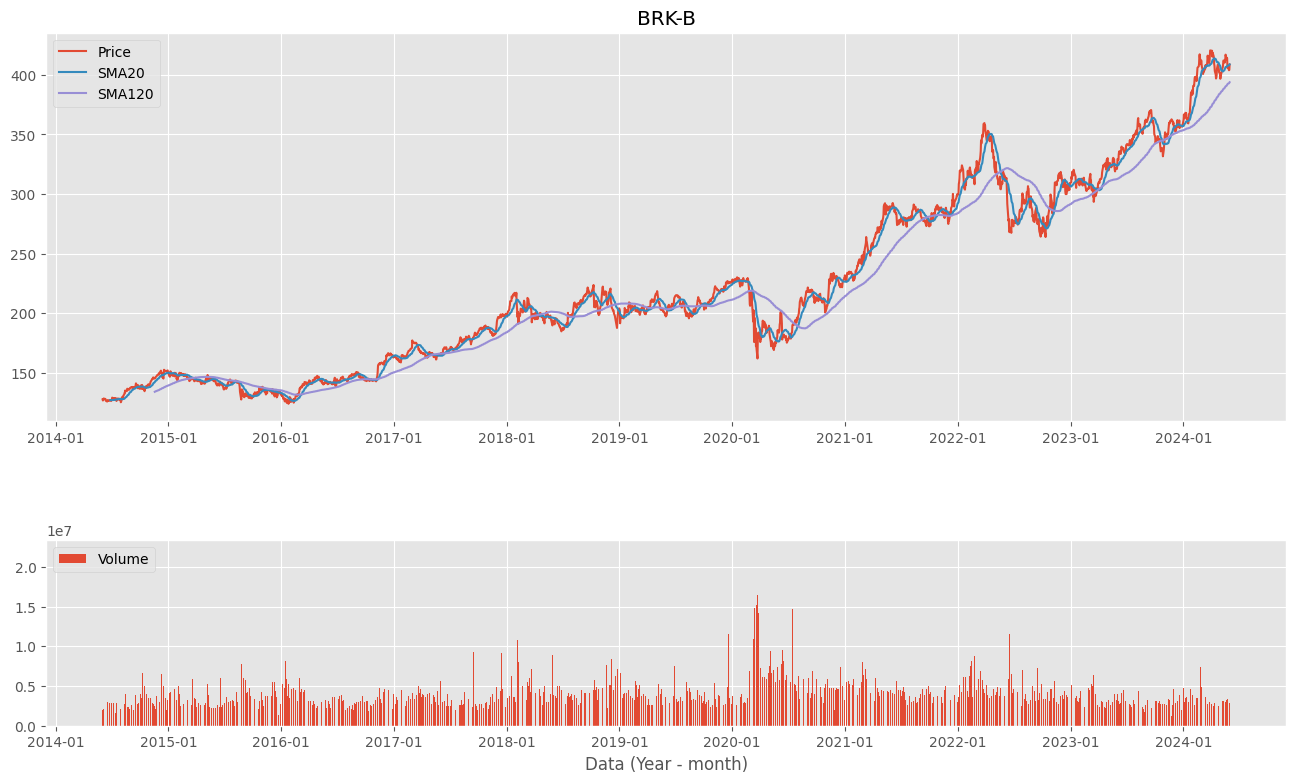

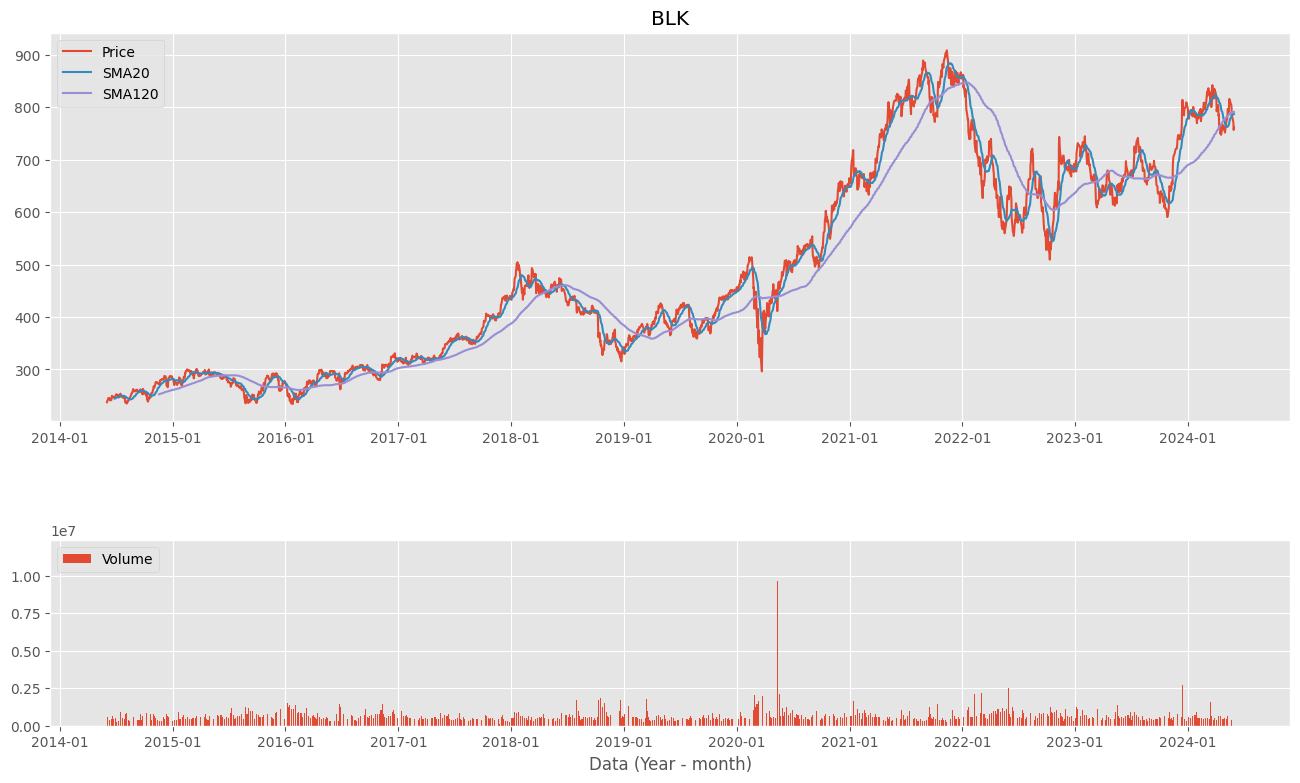

In [41]:
for ticker in selected_stocks:
    dataframe_key = f"df_{ticker}"
    stock_df = stock_dataframes[dataframe_key]

    plt.figure(figsize=(16,9))
    ax1 = plt.subplot2grid((7, 1), (0, 0), rowspan=4, colspan=1, title=ticker)
    ax2 = plt.subplot2grid((7, 1), (5, 0), rowspan=2, colspan=1, sharex=ax1)

    ax1.plot(stock_df['Adj Close'], label='Price')
    ax1.plot(stock_df['SMA20'], label='SMA20')
    ax1.plot(stock_df['SMA120'], label='SMA120')

    ax2.bar(stock_df.index, stock_df['Volume'], label='Volume')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

    ax2.set_xlabel('Data (Year - month)')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')

    plt.show()

#### Implemento la strategia e rendimenti

In [42]:
sma_data = {}

for ticker in selected_stocks:
    dataframe_key = f"df_{ticker}"
    stock_df = stock_dataframes[dataframe_key]

    stock_df['Price_Yesterday'] = stock_df['Adj Close'].shift(1)
    stock_df['Change'] = stock_df['Adj Close'] / stock_df['Price_Yesterday']
    stock_df['Invested_SMA'] = stock_df.apply(
        lambda row: 1 if row['SMA20'] > row['SMA120'] else 0, axis=1
    )

    sma_key = f"sma_{ticker}"
    sma_data[sma_key] = stock_df[stock_df['Invested_SMA'] == 1]

#### Calcolo il prodotto cumulativo

In [43]:
sma_data[sma_key] = sma_data[sma_key].copy()
for ticker in selected_stocks:
    sma_key = f"sma_{ticker}"
    sma_data[sma_key]['Return'] = np.cumprod(sma_data[sma_key]['Change'].values)

C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_7696\3358332731.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma_data[sma_key]['Return'] = np.cumprod(sma_data[sma_key]['Change'].values)
C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_7696\3358332731.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma_data[sma_key]['Return'] = np.cumprod(sma_data[sma_key]['Change'].values)
C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_7696\3358332731.py:4: SettingWithCopyWarning: 
A va

#### Calcolo ritorno medio, volatilita' annualizzata e Sharpe ratio

In [44]:
for ticker in selected_stocks:
    sma_data["sma_" + ticker].loc[:, 'rtn'] = sma_data["sma_" + ticker]['Return'].pct_change()
    sma_data["sma_" + ticker].loc[:, 'rtn'].std()*np.sqrt(252)
    sma_data["sma_" + ticker].loc[:, 'rtn'].mean()*252 / (sma_data["sma_" + ticker]['rtn'].std()*np.sqrt(252))

# Mostro un ticker di esempio
sma_data["sma_AVGO"]

C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_7696\3397941728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma_data["sma_" + ticker].loc[:, 'rtn'] = sma_data["sma_" + ticker]['Return'].pct_change()
C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_7696\3397941728.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sma_data["sma_" + ticker].loc[:, 'rtn'] = sma_data["sma_" + ticker]['Return'].pct_change()
C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_7696\3397941728.py:2: S

Adj Close   Volume        SMA20       SMA120  Price_Yesterday  \
Date                                                                          
2014-11-18    70.057007  2002500    65.526782    59.796918        67.842094   
2014-11-19    68.401588  1876300    65.848291    59.912918        70.057007   
2014-11-20    68.922699  1512100    66.175928    60.034465        68.401588   
2014-11-21    69.137314  1746100    66.496285    60.156787        68.922699   
2014-11-24    69.850090  1187600    66.863011    60.283401        69.137314   
...                 ...      ...          ...          ...              ...   
2024-05-23  1393.290039  3103900  1343.982507  1233.163565      1392.239990   
2024-05-24  1407.839966  1672100  1347.171008  1237.213752      1393.290039   
2024-05-28  1412.449951  2291900  1350.862506  1241.352165      1407.839966   
2024-05-29  1390.670044  2686100  1355.382507  1245.398698      1412.449951   
2024-05-30  1364.079956  2172800  1361.443506  1249.301953      1390.670044   

              Change  Invested_SMA    Return       rtn  
Date                                                    
2014-11-18  1.032648             1  1.032648       NaN  
2014-11-19  0.976370             1  1.008247 -0.023630  
2014-11-20  1.007618             1  1.015928  0.007618  
2014-11-21  1.003114             1  1.019092  0.003114  
2014-11-24  1.010310             1  1.029598  0.010310  
...              ...           ...       ...       ...  
2024-05-23  1.000754             1  9.772093  0.000754  
2024-05-24  1.010443             1  9.874141  0.010443  
2024-05-28  1.003275             1  9.906474  0.003275  
2024-05-29  0.984580             1  9.753717 -0.015420  
2024-05-30  0.980880             1  9.567222 -0.019120  

[1851 rows x 9 columns]

#### Calcolo il rendimento con strategia "Buy and Hold"

In [45]:
for ticker in selected_stocks:
    dataframe_key = f"df_{ticker}"
    stock_data = stock_dataframes[dataframe_key]

    stock_data['Buy_and_hold'] = np.cumprod(stock_data['Change'])
    stock_data['rtn'] = stock_data['Buy_and_hold'].pct_change()
    daily_return_std = stock_data['rtn'].std()

#### Confronto i rendimenti

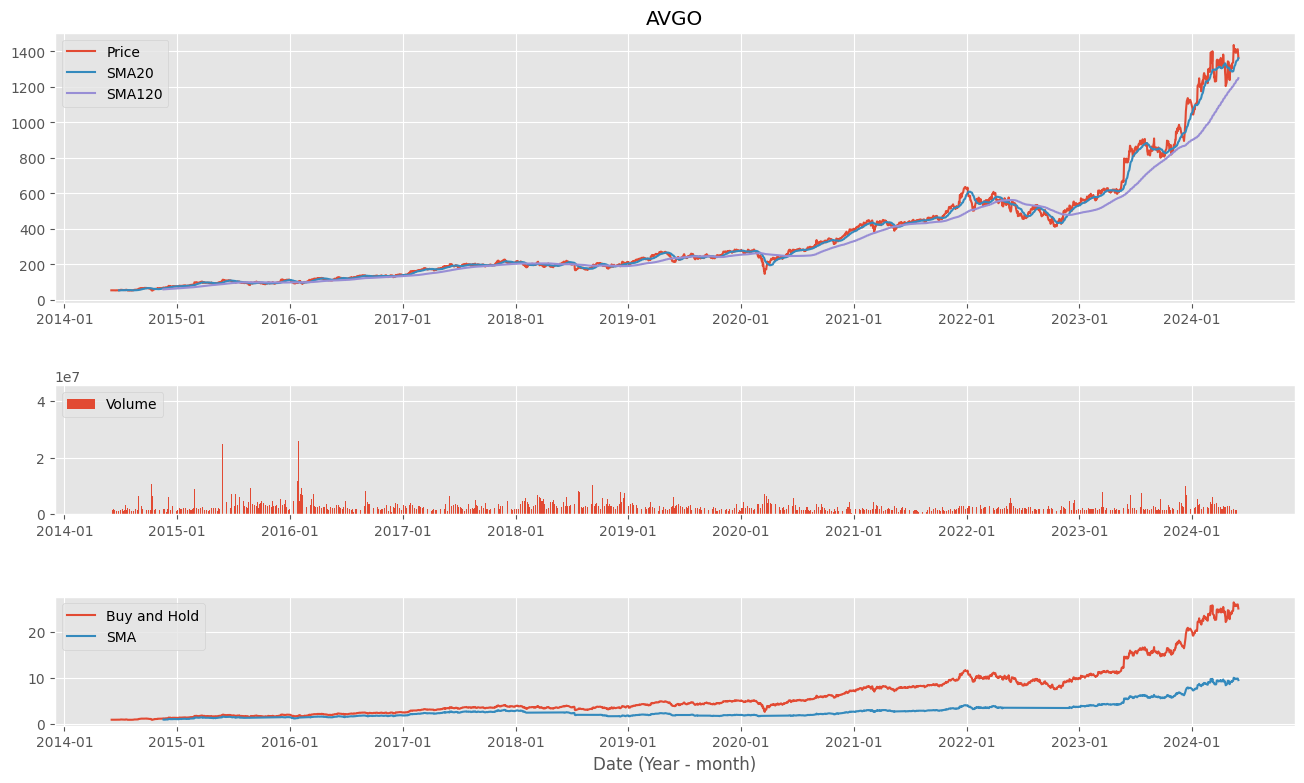

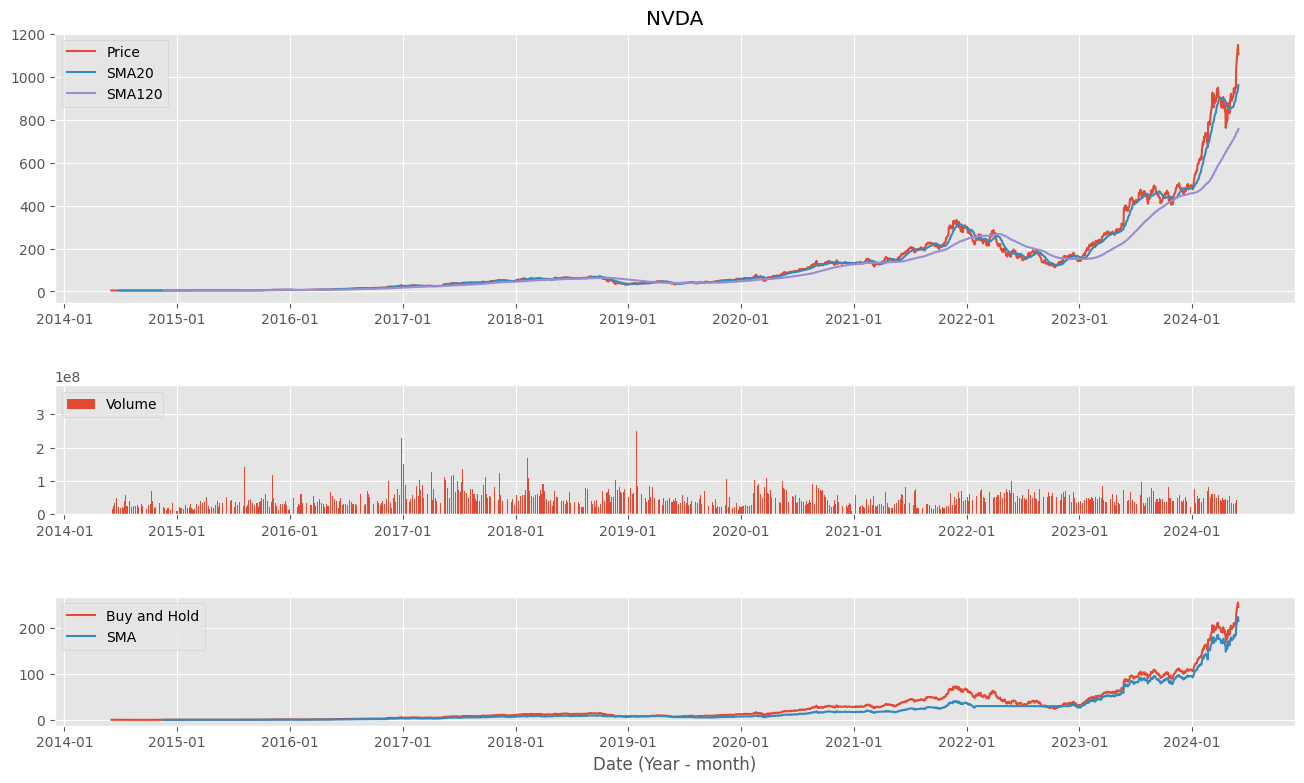

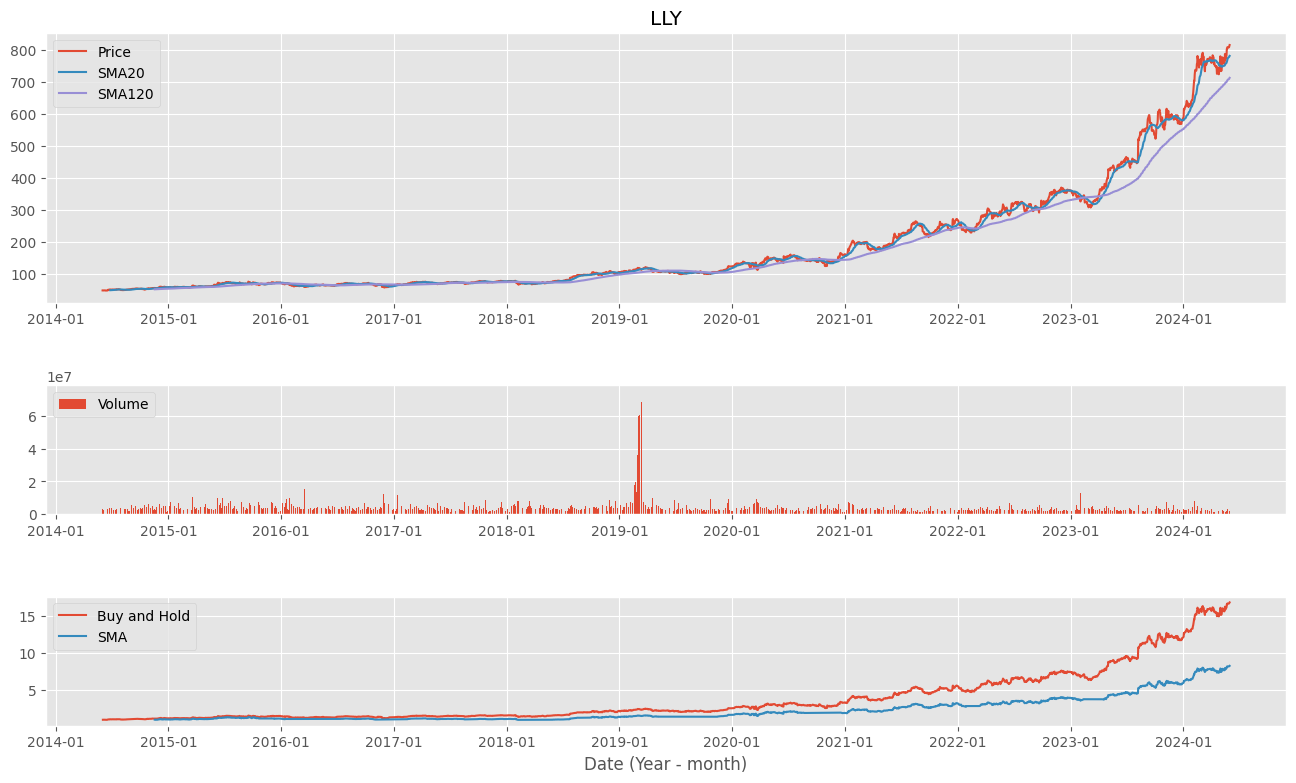

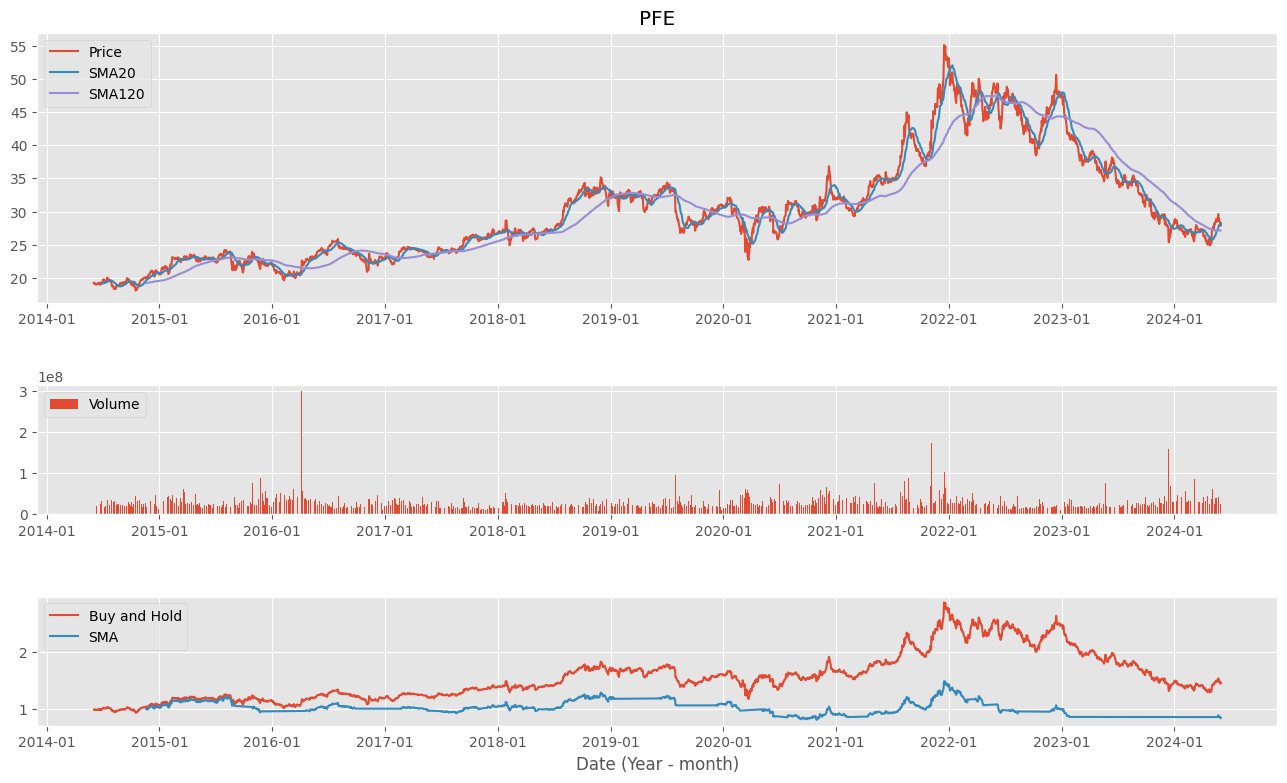

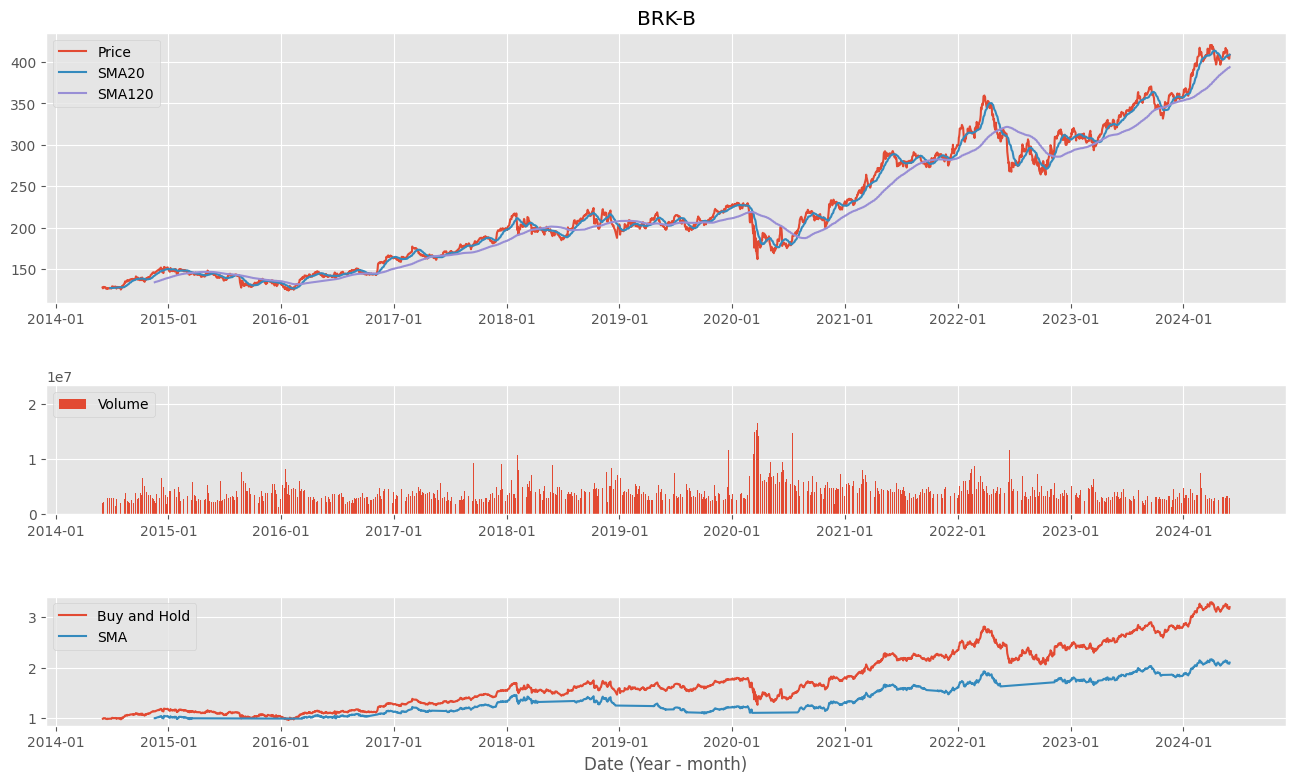

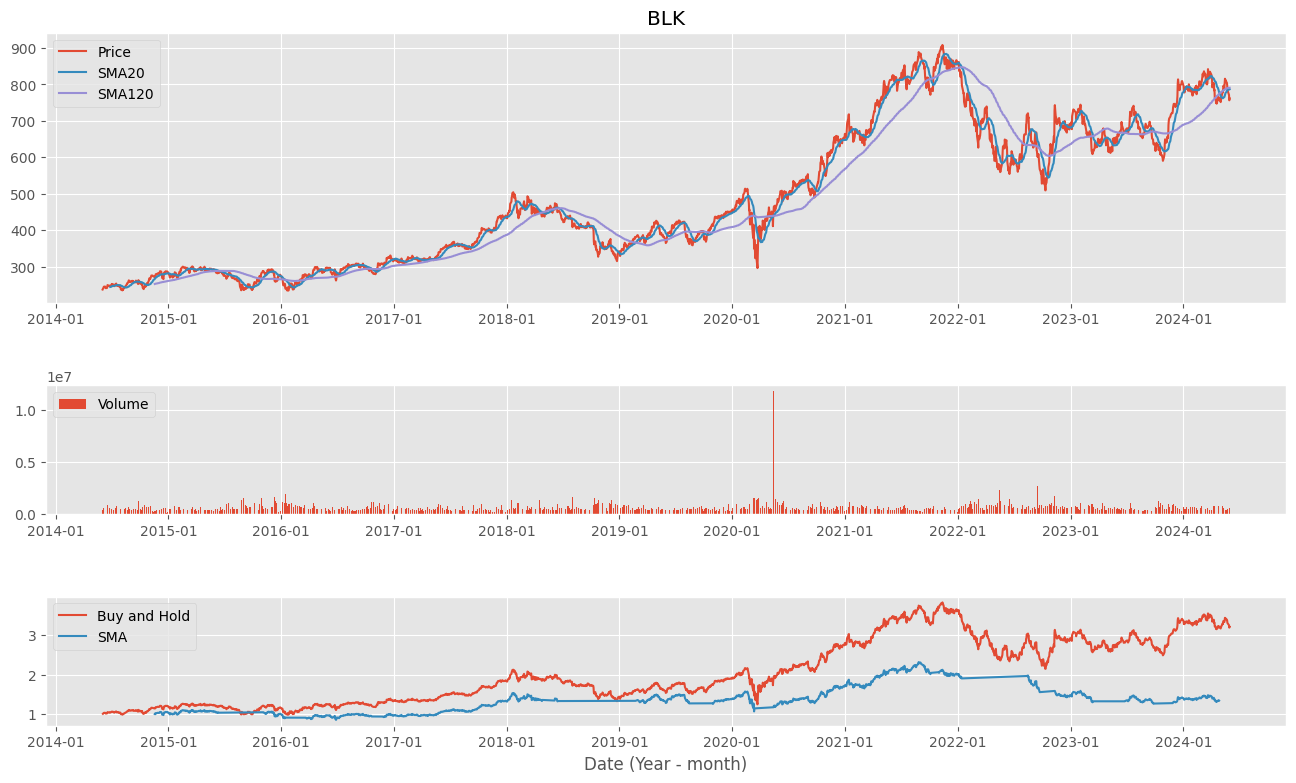

In [46]:
for ticker in selected_stocks:
    stock_data = stock_dataframes[f"df_{ticker}"]
    stock_sma_data = sma_data[f"sma_{ticker}"]


    plt.figure(figsize=(16,9))

    ax1 = plt.subplot2grid((10, 1), (0, 0), rowspan=4, colspan=1, title=ticker)
    ax2 = plt.subplot2grid((10, 1), (5, 0), rowspan=2, colspan=1, sharex=ax1)
    ax3 = plt.subplot2grid((10, 1), (8, 0), rowspan=2, colspan=1, sharex=ax1)

    ax1.plot(stock_data['Adj Close'], label='Price')
    ax1.plot(stock_data['SMA20'], label='SMA20')
    ax1.plot(stock_data['SMA120'], label='SMA120')

    ax2.bar(stock_data.index, stock_data['Volume'], label='Volume')

    ax3.plot(stock_data['Buy_and_hold'], label='Buy and Hold')
    ax3.plot(stock_sma_data['Return'], label='SMA')

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax3.set_xlabel('Date (Year - month)')

    ax1.legend(loc='upper left')
    ax2.legend(loc='upper left')
    ax3.legend(loc='upper left')
    plt.show()

#### Download dei dataframe con il benchmark di mercato e benchmark risk-free

In [47]:
market_benchmark = '^GSPC'
risk_free_rate = '^IRX'

capm_data = {}

for ticker in selected_stocks:
    dataframe_key = f"capm_{ticker}"
    capm_data[dataframe_key] = yf.download([ticker, market_benchmark, risk_free_rate], start=start_date, end=end_date)

[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed
[*********************100%%**********************]  3 of 3 completed


#### Calcolo di beta rispetto al benchmark di mercato

In [48]:
assets_beta = {}

for ticker in selected_stocks:
    beta_key = f'beta_{ticker}'
    
    capm_data_key = f'capm_{ticker}'
    capm_data_df = capm_data[capm_data_key]['Adj Close']
    capm_data_df = capm_data_df.rename(columns={ticker: 'asset', market_benchmark: 'market', risk_free_rate: 'risk_free'})
    
    capm_data_df = capm_data_df.resample('M').mean()
    capm_data_df['mrf'] = (1 + capm_data_df['risk_free'] / 100)**(30 / 360) - 1
    capm_data_df['asset_nmr'] = capm_data_df['asset'].pct_change() - capm_data_df['mrf']
    capm_data_df['market_nmr'] = capm_data_df['market'].pct_change() - capm_data_df['mrf']

    capm_data_df.dropna(inplace=True)
    
    regression_df = capm_data_df[['asset_nmr', 'market_nmr']]
    covariance = regression_df.cov().iloc[0, 1]
    market_variance = regression_df['market_nmr'].var()
    assets_beta[beta_key] = covariance / market_variance

    y = regression_df.pop('asset_nmr')
    X = sm.add_constant(regression_df)

    model = sm.OLS(y, X).fit()
    
    print('\n' + ticker + '\n')
    print(model.summary())

for beta in assets_beta:
    print(beta + ': ', assets_beta[beta])

C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_7696\4159103230.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  capm_data_df = capm_data_df.resample('M').mean()
C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_7696\4159103230.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  capm_data_df = capm_data_df.resample('M').mean()
C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_7696\4159103230.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  capm_data_df = capm_data_df.resample('M').mean()
C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_7696\4159103230.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  capm_data_df = capm_data_df.resample('M').mean()



AVGO

                            OLS Regression Results                            
Dep. Variable:              asset_nmr   R-squared:                       0.350
Model:                            OLS   Adj. R-squared:                  0.344
Method:                 Least Squares   F-statistic:                     62.97
Date:                Tue, 04 Jun 2024   Prob (F-statistic):           1.41e-12
Time:                        21:45:21   Log-Likelihood:                 172.79
No. Observations:                 119   AIC:                            -341.6
Df Residuals:                     117   BIC:                            -336.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0192      0.005      3.583  

C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_7696\4159103230.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  capm_data_df = capm_data_df.resample('M').mean()
C:\Users\Alessandro Zanotti\AppData\Local\Temp\ipykernel_7696\4159103230.py:10: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  capm_data_df = capm_data_df.resample('M').mean()


#### Scarico i Data Factors

In [49]:
ff_data_url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"

urllib.request.urlretrieve(ff_data_url,'fama_french.zip')

with zipfile.ZipFile('fama_french.zip', 'r') as zip_ref:
    zip_ref.extractall()

factor_df = pd.read_csv('F-F_Research_Data_Factors.csv', skiprows=3)

#Filtro i dati
search_string = ' Annual Factors: January-December '
matching_indices = factor_df.iloc[:, 0] == search_string
start_of_annual_index = factor_df[matching_indices].index[0]
factor_df = factor_df[factor_df.index < start_of_annual_index]

#Rinomino e formatto le colonne
factor_df.columns = ['data', 'mkt', 'smb', 'hml', 'rf']
factor_df['data'] = pd.to_datetime(factor_df['data'], format='%Y%m').dt.strftime("%Y-%m")

#### Scarico i DataFrames per Fama-French

In [50]:
fama_french_data = {}

for ticker in selected_stocks:
    dataframe_key = f"ff_df_{ticker}"
    fama_french_data[dataframe_key] = yf.download(ticker, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


#### Filtro la tabella con start_date e end_date

In [51]:
factor_df = factor_df.set_index('data')
factor_df = factor_df[start_date:end_date]
factor_df = factor_df.apply(pd.to_numeric, errors='coerce').div(100)

#### Strima del modello a tre fattori

In [52]:
for ticker in selected_stocks:
    dataframe_key = f"ff_df_{ticker}"

    stock_returns = fama_french_data[dataframe_key]['Adj Close'].resample('ME').last().pct_change().dropna()
    
    stock_returns.index = stock_returns.index.strftime('%Y-%m')
    stock_returns.name = 'rtn'

    ff_data = factor_df.join(stock_returns)
    
    ff_data['excess_rtn'] = ff_data['rtn'] - ff_data['rf']

    average_risk_free_rate = ff_data['rf'].mean()
    average_market_premium = ff_data['mkt'].mean()

    ff_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml', data=ff_data).fit()
    
    print('\n' + ticker + '\n')
    print(ff_model.summary())


AVGO

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.344
Model:                            OLS   Adj. R-squared:                  0.327
Method:                 Least Squares   F-statistic:                     19.92
Date:                Tue, 04 Jun 2024   Prob (F-statistic):           1.88e-10
Time:                        21:45:24   Log-Likelihood:                 149.73
No. Observations:                 118   AIC:                            -291.5
Df Residuals:                     114   BIC:                            -280.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0197      0.007      2.999  

#### Calcolo i rendimenti attesi per ogni asset con CAPM

In [53]:
predicted_returns = {}

for ticker in selected_stocks:
    return_key = f"rtn_{ticker}"

    expected_return = average_risk_free_rate + (assets_beta[f'beta_{ticker}'] * average_market_premium)
    annualized_expected_return = expected_return * 12
    predicted_returns[return_key] = annualized_expected_return
    print(f"{ticker}: {annualized_expected_return}")

AVGO: 0.14871095329145817
NVDA: 0.23605767686349183
LLY: 0.050582770090241
PFE: 0.08653163638578501
BRK-B: 0.10227395832616595
BLK: 0.18240569511886898


#### Scarico i prezzi e le impostazioni per il portafoglio

In [54]:
number_of_portfolios = 10 ** 5
trading_days_per_year = 252
portfolio_start_date = '2014-05-31'
portfolio_end_date = '2023-05-31'

number_of_assets = len(selected_stocks)

portfolio_data = yf.download(selected_stocks, start=portfolio_start_date, end=portfolio_end_date)

[*********************100%%**********************]  6 of 6 completed


In [55]:
returns_df = portfolio_data['Adj Close'].pct_change().dropna()
annualized_avg_returns = returns_df.mean() * trading_days_per_year
annualized_covariance_matrix = returns_df.cov() * trading_days_per_year

#### Definisco la funzione per calcolare il rendimento e la varianza di un portafoglio

In [56]:
def calculate_portfolio_return_and_variance(weights, expected_returns, covariance_matrix):
    portfolio_return = np.sum(expected_returns * weights)
    portfolio_variance = np.dot(weights.T, np.dot(covariance_matrix, weights))
    return portfolio_return, portfolio_variance

#### Definisco la funzione per generare portafogli casuali

In [57]:
def monte_carlo_simulation(expected_returns, covariance_matrix, num_portfolios):
    num_assets = len(expected_returns)
    results = np.zeros((3, num_portfolios))
    random_weights = []

    for i in range(num_portfolios):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        random_weights.append(weights)

        portfolio_return, portfolio_variance = calculate_portfolio_return_and_variance(weights, expected_returns, covariance_matrix)

        results[0, i] = portfolio_return
        results[1, i] = portfolio_variance
        results[2, i] = portfolio_return / np.sqrt(portfolio_variance)

    return results, random_weights

#### Genero i risultati e i pesi casuali

In [58]:
results, random_weights = monte_carlo_simulation(annualized_avg_returns, annualized_covariance_matrix, number_of_portfolios)

#### Calcolo i valori migliori

In [59]:
best_index = np.argmax(results[2])
best_weights = random_weights[best_index]

best_return = results[0, best_index]
best_variance = results[1, best_index]

#### Calcolo la frontiera efficiente tramite metodo Monte Carlo sui rendimenti passati

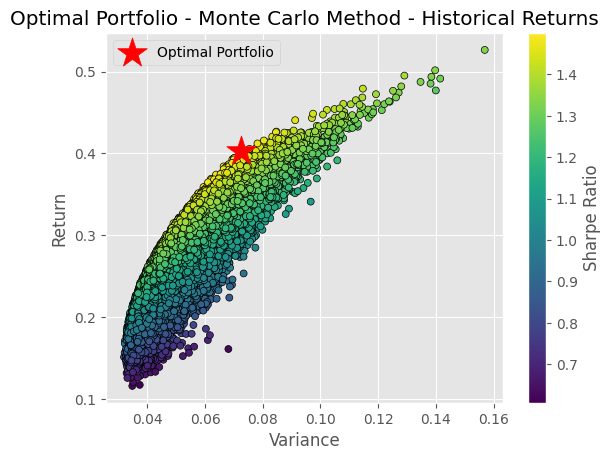

In [60]:
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', edgecolors='black', s=25)
plt.colorbar(label='Sharpe Ratio')

plt.scatter(best_variance, best_return, marker='*', color='r', s=500, label='Optimal Portfolio')

plt.xlabel('Variance')
plt.ylabel('Return')
plt.title('Optimal Portfolio - Monte Carlo Method - Historical Returns')

plt.legend()

plt.show()

#### Calcolo la media dei rendimenti previsti

In [61]:
expected_returns = np.array(list(predicted_returns.values()))

#### Genero i risultati e i pesi casuali

In [62]:
results, random_weights = monte_carlo_simulation(expected_returns, annualized_covariance_matrix, number_of_portfolios)

#### Calcolo i valori migliori

In [63]:
best_index = np.argmax(results[2])
best_weights = random_weights[best_index]

best_return = results[0, best_index]
best_variance = results[1, best_index]

#### Calcolo la frontiera efficiente tramite metodo Monte Carlo sui rendimenti previsti

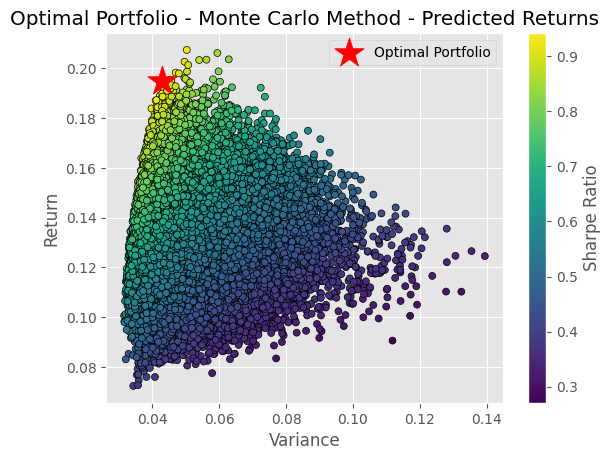

In [64]:
plt.scatter(results[1, :], results[0, :], c=results[2, :], cmap='viridis', edgecolors='black', s=25)
plt.colorbar(label='Sharpe Ratio')

plt.scatter(best_variance, best_return, marker='*', color='r', s=500, label='Optimal Portfolio')

plt.xlabel('Variance')
plt.ylabel('Return')
plt.title('Optimal Portfolio - Monte Carlo Method - Predicted Returns')

plt.legend()

plt.show()

#### Calcolo il Beta del portafoglio rispetto al mercato
- Rendimento SP500 e miglior rendimento atteso portafoglio 

In [65]:
portfolio_beta = best_return / expected_returns

print(f"Portfolio Beta: {portfolio_beta}")

Portfolio Beta: [1.31149323 0.82621083 3.85572812 2.25389716 1.90697038 1.06922873]
